# Predicting Flight Delay Duration Using Machine Learning

## 1. Problem Description and Project Objective

Flight delays represent a major operational challenge for airlines, leading to reduced efficiency, increased operational costs, additional crew expenses, and decreased passenger satisfaction. Persistent delays can also negatively affect long-term customer demand and airline reputation.

This project addresses the **Tunisair Flight Delay Prediction Challenge**, which aims to predict the **expected delay duration for individual flights operated by the Tunisian national airline, Tunisair**.

Each record in the dataset corresponds to a single flight instance and contains operational, temporal, geographic, and aircraft-related information. The target variable represents the **delay duration (in minutes)** associated with each flight.

The main objective of this project is to develop a machine learning model capable of accurately estimating flight delays before departure, enabling airlines and airport operators to:

* Improve operational planning and resource allocation
* Anticipate congestion-related disruptions
* Reduce cascading delays across flight schedules
* Enhance passenger experience through better communication and scheduling decisions

To achieve this objective, the project follows a structured pipeline including data exploration, feature engineering, model training, and performance evaluation, with a strong focus on avoiding data leakage and ensuring real-world applicability of the predictive model.

Ultimately, this solution aims to provide actionable insights that support data-driven decision-making within airline operations.


## 2. Technical Setup and Utilities

### 2.1 Imports

In [2]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# ============================================================
# 📐 Statistics & Statistical Modeling
# ============================================================
import scipy.stats as stats
import statsmodels.api as sm

# ============================================================
# 🤖 Machine Learning — Core Utilities
# ============================================================
from sklearn.model_selection import (KFold, cross_val_score, GridSearchCV, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, PolynomialFeatures)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# ============================================================
# 📈 Linear & Regularized Models
# ============================================================
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV)

# ============================================================
# 🌳 Tree-Based Models
# ============================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

# ============================================================
# 🌊 Kernel-Based Models
# ============================================================
from sklearn.svm import SVR

# ============================================================
# 🚀 Gradient Boosting (External)
# ============================================================
from xgboost import XGBRegressor

# ============================================================
# 🚨 Anomaly Detection (used in EDA / preprocessing)
# ============================================================
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling
# ============================================================
MAIN_COLOR = "#B388EB"
RANDOM_STATE = 1234

### 2.2  IQR-Based Outlier Handling Utilities

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k

    def fit(self, X, y=None):
        # Ensure DataFrame for column-wise operations
        X = pd.DataFrame(X)

        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1

        self.lower_bounds_ = q1 - self.k * iqr
        self.upper_bounds_ = q3 + self.k * iqr

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            X[col] = X[col].clip(
                lower=self.lower_bounds_[col],
                upper=self.upper_bounds_[col]
            )

        return X

## 3. Data Loading & Initial Exploration

### 3.1 Load Raw Datasets

In [177]:
# ----------------------------
# Load datasets
# ----------------------------

train_path = "../data/Zindi/Train.csv"
test_path = "../data/Zindi/Test.csv"

airports_path = "../data/airportsdata/airports.csv"
iata_macs_path = "../data/airportsdata/iata_macs.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

airports_df = pd.read_csv(airports_path)
iata_macs_df = pd.read_csv(iata_macs_path)


### 3.2 Basic Dataset Inspection

In [178]:

# ----------------------------
# Basic inspection
# ----------------------------

print("=== TRAIN ===")
print(train_df.shape)
display(train_df.info())
display(train_df.head())

print("\n=== TEST ===")
print(test_df.shape)
display(test_df.info())
display(test_df.head())

print("\n=== AIRPORTS ===")
print(airports_df.shape)
display(airports_df.info()) 
display(airports_df.head())

print("\n=== IATA MACS ===")
print(iata_macs_df.shape)
display(iata_macs_df.info())
display(iata_macs_df.head())


# ----------------------------
# Column overview
# ----------------------------

print("\nTrain columns:\n", train_df.columns.tolist())
print("\nTrain columns:\n", test_df.columns.tolist())
print("\nAirports columns:\n", airports_df.columns.tolist())
print("\nIATA MACS columns:\n", iata_macs_df.columns.tolist())


=== TRAIN ===
(107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0



=== TEST ===
(9333, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      9333 non-null   object
 1   DATOP   9333 non-null   object
 2   FLTID   9333 non-null   object
 3   DEPSTN  9333 non-null   object
 4   ARRSTN  9333 non-null   object
 5   STD     9333 non-null   object
 6   STA     9333 non-null   object
 7   STATUS  9333 non-null   object
 8   AC      9333 non-null   object
dtypes: object(9)
memory usage: 656.4+ KB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ



=== AIRPORTS ===
(28270, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28270 entries, 0 to 28269
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   icao       28270 non-null  object 
 1   iata       7859 non-null   object 
 2   name       28270 non-null  object 
 3   city       25440 non-null  object 
 4   subd       27497 non-null  object 
 5   country    28207 non-null  object 
 6   elevation  28270 non-null  float64
 7   lat        28270 non-null  float64
 8   lon        28270 non-null  float64
 9   tz         28270 non-null  object 
 10  lid        12610 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.4+ MB


None

,icao,iata,name,city,subd,country,elevation,lat,lon,tz,lid
0,00AA,NaN,Aero B Ranch Airport,Leoti,Kansas,US,3435.0,38.70402,-101.47391,America/Chicago,00AA
1,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,252.0,59.94889,-151.69222,America/Anchorage,00AK
2,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820.0,34.86481,-86.77028,America/Chicago,00AL
3,00AN,NaN,Katmai Lodge Airport,King Salmon,Alaska,US,80.0,59.09347,-156.45583,America/Anchorage,00AN
4,00AR,NaN,Arland Airport,Bennington,Kansas,US,1352.0,38.96965,-97.60156,America/Chicago,00AR



=== IATA MACS ===
(89, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       89 non-null     object
 1   City Code     89 non-null     object
 2   City Name     89 non-null     object
 3   Airport Code  89 non-null     object
 4   Airport Name  89 non-null     object
dtypes: object(5)
memory usage: 3.6+ KB


None

,Country,City Code,City Name,Airport Code,Airport Name
0,AE,DXB,Dubai,DWC,Al Maktoum Intl
1,AE,DXB,Dubai,DXB,International
2,AR,BUE,Buenos Aires,AEP,Jorge Newbery
3,AR,BUE,Buenos Aires,EZE,Ministro Pistarini
4,AU,MEL,Melbourne,AVV,Avalon



Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC', 'target']

Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC']

Airports columns:
 ['icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'lat', 'lon', 'tz', 'lid']

IATA MACS columns:
 ['Country', 'City Code', 'City Name', 'Airport Code', 'Airport Name']


### 3.3 Unique Values & Airport Code Exploration

In [179]:
# ----------------------------
# Unique values in flight data
# ----------------------------

print("Unique DEPSTN airports:", train_df["DEPSTN"].nunique())
print("Unique ARRSTN airports:", train_df["ARRSTN"].nunique())

print("\nSample DEPSTN values:")
print(train_df["DEPSTN"].value_counts().head(10))

print("\nSample ARRSTN values:")
print(train_df["ARRSTN"].value_counts().head(10))


Unique DEPSTN airports: 132
Unique ARRSTN airports: 128

Sample DEPSTN values:
DEPSTN
TUN    42522
DJE    10252
ORY     6755
MIR     5248
MRS     2845
LYS     2358
NCE     2227
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64

Sample ARRSTN values:
ARRSTN
TUN    42572
DJE    10198
ORY     6755
MIR     5251
MRS     2845
LYS     2359
NCE     2228
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64


In [180]:
# ----------------------------
# Unique IATA airports
# ----------------------------

print("Unique IATA airports in airports dataset:", airports_df["iata"].nunique())

print("\nSample IATA values:")
print(airports_df["iata"].value_counts().head(10))


Unique IATA airports in airports dataset: 7859

Sample IATA values:
iata
OCA    1
SGL    1
MNL    1
DRP    1
LAO    1
CRK    1
SFS    1
ENI    1
OGN    1
RNJ    1
Name: count, dtype: int64


In [181]:
# ----------------------------
# Inspect Airport Code in iata_macs
# ----------------------------

print("Unique Airport Codes in iata_macs:",
      iata_macs_df["Airport Code"].nunique())

print("\nSample Airport Codes from iata_macs:")
print(iata_macs_df["Airport Code"].value_counts().head(10))


Unique Airport Codes in iata_macs: 89

Sample Airport Codes from iata_macs:
Airport Code
DWC    1
NGO    1
DKR    1
BMA    1
ARN    1
VKO    1
SVO    1
DME    1
TRF    1
OSL    1
Name: count, dtype: int64


### 3.4 Dataset Relationship & Join Feasibility Check

In [182]:
# ----------------------------
# Check matching coverage
# ----------------------------

dep_not_found = set(train_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found = set(train_df["ARRSTN"]) - set(airports_df["iata"])

print("DEPSTN not found in airports IATA:", len(dep_not_found))
print("ARRSTN not found in airports IATA:", len(arr_not_found))

print("\nSample missing DEPSTN:", list(dep_not_found)[:10])
print("Sample missing ARRSTN:", list(arr_not_found)[:10])

# ----------------------------
# Check matching coverage (TEST)
# ----------------------------

dep_not_found_test = set(test_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found_test = set(test_df["ARRSTN"]) - set(airports_df["iata"])

print("\n\nTEST DEPSTN not found in airports IATA:", len(dep_not_found_test))
print("TEST ARRSTN not found in airports IATA:", len(arr_not_found_test))

print("\nSample missing TEST DEPSTN:", list(dep_not_found_test)[:10])
print("Sample missing TEST ARRSTN:", list(arr_not_found_test)[:10])

DEPSTN not found in airports IATA: 1
ARRSTN not found in airports IATA: 1

Sample missing DEPSTN: ['SXF']
Sample missing ARRSTN: ['SXF']


TEST DEPSTN not found in airports IATA: 1
TEST ARRSTN not found in airports IATA: 1

Sample missing TEST DEPSTN: ['SXF']
Sample missing TEST ARRSTN: ['SXF']


In [183]:
dep_not_in_macs = set(train_df["DEPSTN"]) - set(iata_macs_df["Airport Code"])

print("DEPSTN not found in iata_macs:", len(dep_not_in_macs))
print("Sample missing DEPSTN:", list(dep_not_in_macs)[:10])


arr_not_in_macs = set(train_df["ARRSTN"]) - set(iata_macs_df["Airport Code"])

print("ARRSTN not found in iata_macs:", len(arr_not_in_macs))
print("Sample missing ARRSTN:", list(arr_not_in_macs)[:10])


DEPSTN not found in iata_macs: 114
Sample missing DEPSTN: ['MIR', 'HBE', 'AMM', 'BEG', 'AMS', 'OUA', 'SXF', 'PRG', 'DOH', 'MRS']
ARRSTN not found in iata_macs: 110
Sample missing ARRSTN: ['MIR', 'HBE', 'AMM', 'BEG', 'AMS', 'OUA', 'SXF', 'PRG', 'DOH', 'MRS']


🔍 Observation: Airport Code Coverage

The airports.csv dataset provides almost full coverage for the flight dataset. Only one airport code (SXF) from both DEPSTN and ARRSTN was not found in the airports IATA list.

In contrast, the iata_macs.csv dataset shows very low coverage. More than 110 airport codes from the flight dataset are missing in this file. This indicates that iata_macs is mainly designed for city-to-airport mapping and is not suitable for enriching airport-level features.

Therefore, airports.csv is selected as the main source for joining airport information, while iata_macs.csv will not be used in the modeling pipeline.

### 3.5 Handling Missing Airport Code (SXF)

The airport code SXF (Berlin Schönefeld Airport) appears in the flight dataset but is missing from the airports reference dataset. This is expected because SXF was closed and merged into BER (Berlin Brandenburg Airport) in recent airport databases.

Since both airports are located in the same metropolitan area and have very similar geographic properties, SXF is manually mapped to BER prior to performing the airport join. This approach avoids data loss and ensures consistent geographic feature enrichment.

In [184]:
# ----------------------------
# Manual mapping: SXF -> BER
# ----------------------------

train_df["DEPSTN"] = train_df["DEPSTN"].replace("SXF", "BER")
train_df["ARRSTN"] = train_df["ARRSTN"].replace("SXF", "BER")

test_df["DEPSTN"] = test_df["DEPSTN"].replace("SXF", "BER")
test_df["ARRSTN"] = test_df["ARRSTN"].replace("SXF", "BER")


Airport code normalization (SXF → BER) was applied prior to the merge operation to ensure consistent key matching and prevent missing geographic attributes during dataset enrichment.

### 3.6 Airport Data Enrichment (Departure & Arrival Join)

In this step, airport-level geographic and contextual information is merged into the flight dataset.
The airports reference dataset is joined twice:

Once for the departure airport (DEPSTN)

Once for the arrival airport (ARRSTN)

This allows adding location-based features such as latitude, longitude, elevation, country, and timezone for both origin and destination airports.

In [185]:
# ----------------------------
# Prepare airport reference tables
# ----------------------------

dep_airports = airports_df.add_prefix("dep_")
arr_airports = airports_df.add_prefix("arr_")


# ----------------------------
# Merge departure airport info
# ----------------------------

train_df = train_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)

test_df = test_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)


# ----------------------------
# Merge arrival airport info
# ----------------------------

train_df = train_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)

test_df = test_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)


In [186]:
train_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city',
       'dep_subd', 'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon',
       'dep_tz', 'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city',
       'arr_subd', 'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon',
       'arr_tz', 'arr_lid'],
      dtype='object')

In [187]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             107833 non-null  object 
 1   DATOP          107833 non-null  object 
 2   FLTID          107833 non-null  object 
 3   DEPSTN         107833 non-null  object 
 4   ARRSTN         107833 non-null  object 
 5   STD            107833 non-null  object 
 6   STA            107833 non-null  object 
 7   STATUS         107833 non-null  object 
 8   AC             107833 non-null  object 
 9   target         107833 non-null  float64
 10  dep_icao       107833 non-null  object 
 11  dep_iata       107833 non-null  object 
 12  dep_name       107833 non-null  object 
 13  dep_city       107833 non-null  object 
 14  dep_subd       105783 non-null  object 
 15  dep_country    107833 non-null  object 
 16  dep_elevation  107833 non-null  float64
 17  dep_lat        107833 non-nul

In [190]:
train_df.head()
train_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city',
       'dep_subd', 'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon',
       'dep_tz', 'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city',
       'arr_subd', 'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon',
       'arr_tz', 'arr_lid'],
      dtype='object')

### 3.7 Post-Join Missing Value Check (Airport Features)

This step verifies whether airport information was successfully merged for both departure and arrival airports.
Missing values are inspected to ensure that the join operation produced complete geographic feature coverage.

In [189]:
# ----------------------------
# Check missing values after airport join
# ----------------------------

airport_feature_cols = [
    "dep_lat", "dep_lon", "dep_country", "dep_tz", "dep_elevation",
    "arr_lat", "arr_lon", "arr_country", "arr_tz", "arr_elevation"
]

print("Missing values in TRAIN (airport features):")
print(train_df[airport_feature_cols].isna().sum())

print("\nMissing values in TEST (airport features):")
print(test_df[airport_feature_cols].isna().sum())


Missing values in TRAIN (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64

Missing values in TEST (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64


## 4. Train / Validation Split

### 4.1 Validation Strategy Justification and Data Leakage Considerations

Although flight delay prediction problems are often treated as time-series forecasting tasks, this project is formulated as a standard tabular regression problem.

The model exclusively relies on calendar-based features such as departure time, day of the week, and month of the flight. It does not use historical delay information or lag-based features to predict future delays. As a result, individual flight observations are considered independent, and no temporal dependency between records is assumed.

Furthermore, the competition test set temporally overlaps with the training data period, indicating that the evaluation setup does not represent a strict future forecasting scenario.

Based on these considerations, a random train-validation split (or standard cross-validation) is used throughout the modeling process. This approach avoids data leakage, aligns with the competition setup, and provides a reliable estimate of model generalization performance.

### 4.2 Train / Validation Split

In [194]:
from sklearn.model_selection import train_test_split

# Separate target
y = train_df["target"]
X = train_df.drop(columns=["target"])

# Train / Validation split (random)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Recombine for convenience
train_df_eda = X_train.copy()
train_df_eda["target"] = y_train

val_df = X_val.copy()
val_df["target"] = y_val

train_df.shape, train_df_eda.shape, val_df.shape, y_train.shape, y_val.shape

((107833, 32), (86266, 32), (21567, 32), (86266,), (21567,))

## 5. Exploratory Data Analysis (EDA)

### 5.1 Missing Data Overview

In [195]:
# ----------------------------
# Missing values per column
# ----------------------------

missing_counts = train_df_eda.isna().sum()
missing_percent = (train_df_eda.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

display(missing_summary)


,missing_count,missing_percent
arr_lid,86266,100.00
dep_lid,86266,100.00
arr_subd,1629,1.89
dep_subd,1596,1.85
ID,0,0.00
dep_lon,0,0.00
arr_tz,0,0.00
arr_lon,0,0.00
arr_lat,0,0.00
arr_elevation,0,0.00


**Missing Airport Metadata Observation**

The columns dep_lid and arr_lid contain 100% missing values. These fields represent FAA internal location identifiers, which are only applicable to a limited subset of US airports and are not relevant for a global flight dataset. Therefore, these columns will be removed during the data cleaning stage.

A small fraction of missing values (~1.9%) is observed in the dep_subd and arr_subd columns, which correspond to administrative subdivisions. This is expected for certain countries where subdivision data is not available.

### 5.2 Data Types Overview

In [196]:
# ----------------------------
# Data types summary table
# ----------------------------

dtype_summary = pd.DataFrame({
    "column": train_df_eda.columns,
    "dtype": train_df_eda.dtypes.values
})

display(dtype_summary)


,column,dtype
0,ID,object
1,DATOP,object
2,FLTID,object
3,DEPSTN,object
4,ARRSTN,object
5,STD,object
6,STA,object
7,STATUS,object
8,AC,object
9,dep_icao,object


**Data Type Inspection Summary**

The target variable is correctly stored as a numerical feature (float64), confirming the regression formulation of the problem.

Geographic attributes such as latitude, longitude, and elevation for both departure and arrival airports are stored as numeric values and are ready for modeling.

Date and time-related columns (DATOP, STD, STA) are currently stored as object types and will be converted to appropriate datetime representations during the preprocessing stage.

Categorical attributes (airport codes, aircraft type, country, timezone, and status) are represented as object types and will be handled during feature encoding.

The columns dep_lid and arr_lid contain only missing values and will be removed in the data cleaning phase.

### 5.3 Duplicate Record Check

In [197]:
# ----------------------------
# Check full row duplicates
# ----------------------------

total_duplicates = train_df_eda.duplicated().sum()
print("Total duplicated rows:", total_duplicates)


Total duplicated rows: 0


In [198]:
# ----------------------------
# Check duplicate IDs
# ----------------------------

duplicate_ids = train_df_eda["ID"].duplicated().sum()
print("Duplicate IDs:", duplicate_ids)


Duplicate IDs: 0


In [199]:
# ----------------------------
# Logical duplicate check (flight + date)
# ----------------------------

logical_duplicates = train_df_eda.duplicated(subset=["FLTID", "DATOP"]).sum()
print("Duplicate FLTID + DATOP:", logical_duplicates)


Duplicate FLTID + DATOP: 5812


In [200]:
true_duplicates = train_df_eda.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
).sum()

print("True route-level duplicates:", true_duplicates)


True route-level duplicates: 1344


In [202]:
route_dup_mask = train_df_eda.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"],
    keep=False
)

route_dups = train_df_eda[route_dup_mask]

print(route_dups.shape)


(2181, 32)


In [203]:
route_dups_sorted = route_dups.sort_values(
    by=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
)

route_dups_sorted.head(10)


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,dep_icao,...,arr_name,arr_city,arr_subd,arr_country,arr_elevation,arr_lat,arr_lon,arr_tz,arr_lid,target
68174,train_id_68174,2017-04-25,A 0000,TUN,TUN,2017-04-25 20:00:00,2017-04-26 23.59.00,SCH,TU 32AIMG,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
67845,train_id_67845,2017-04-25,A 0000,TUN,TUN,2017-04-25 07:00:00,2017-04-25 21.00.00,SCH,TU 320IMT,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
66857,train_id_66857,2017-06-19,A 0000,TUN,TUN,2017-06-19 21:00:00,2017-06-20 05.00.00,SCH,TU 32AIMM,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
66558,train_id_66558,2017-06-19,A 0000,TUN,TUN,2017-06-19 05:00:00,2017-06-19 15.00.00,SCH,TU 332IFN,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
67987,train_id_67987,2017-07-19,A 0000,TUN,TUN,2017-07-19 21:00:00,2017-07-20 04.00.00,SCH,TU 32AIML,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
68759,train_id_68759,2017-07-19,A 0000,TUN,TUN,2017-07-19 06:00:00,2017-07-19 13.30.00,SCH,TU 320IMR,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
105694,train_id_105694,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-26 04.45.00,SCH,TU 332IFN,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
106250,train_id_106250,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-25 13.00.00,SCH,TU 320IMW,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
107154,train_id_107154,2018-05-28,A 0000,TUN,TUN,2018-05-28 21:00:00,2018-05-30 04.00.00,SCH,TU 736IOK,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
105240,train_id_105240,2018-05-28,A 0000,TUN,TUN,2018-05-28 07:00:00,2018-05-30 13.30.00,SCH,TU 332IFM,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0


**Interpretation of Route-Level Duplicate Records**

Inspection of route-level duplicate entries shows that records sharing the same flight number, date, and route often differ in scheduled departure and arrival times as well as aircraft identifiers. This indicates that these entries represent multiple operational flight instances rather than erroneous duplicated records. Therefore, these records are retained in the dataset.

### 5.4 Numerical Feature Distribution and Outlier Analysis

#### 5.4.1 Target Variable

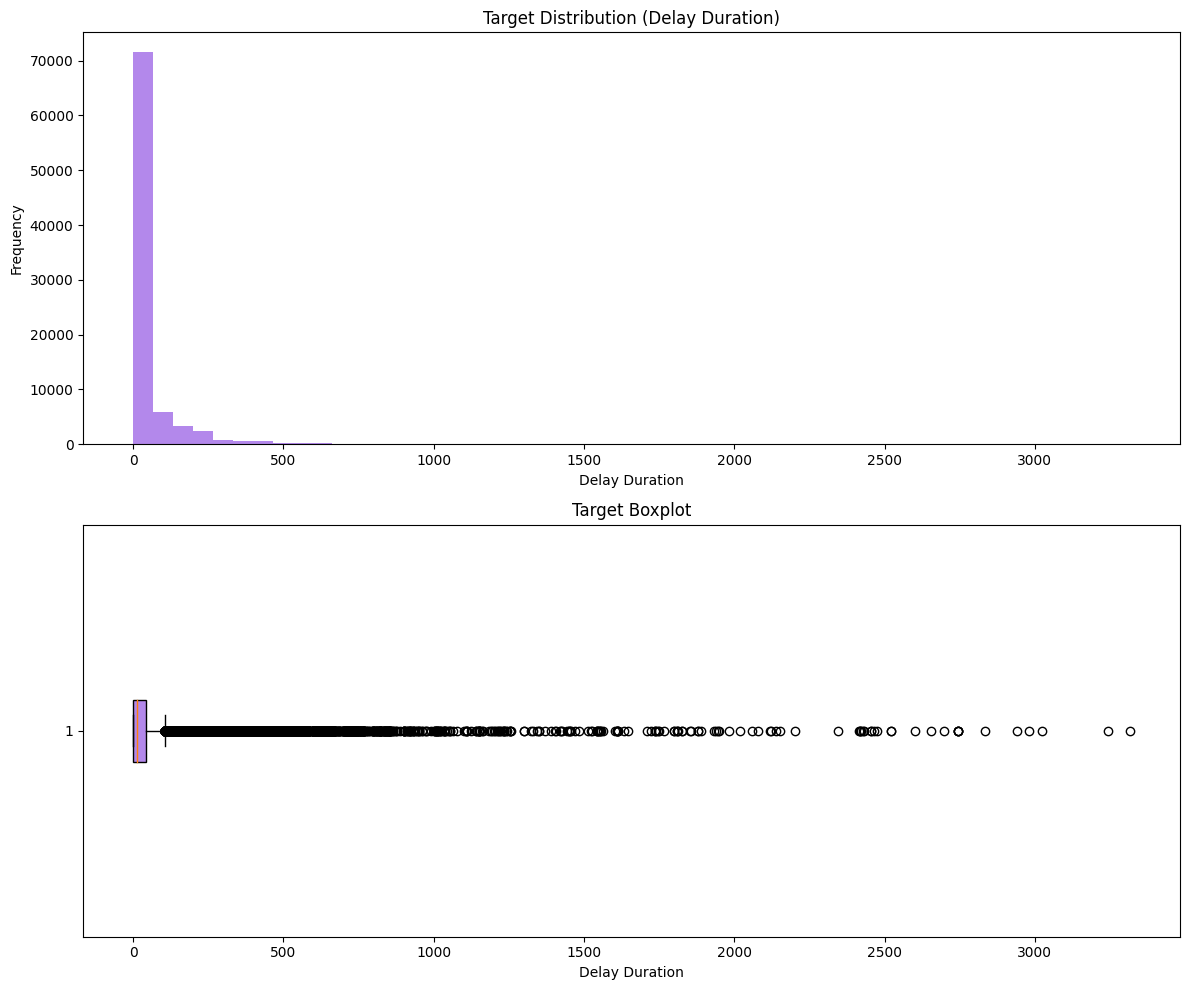

In [205]:
import matplotlib.pyplot as plt

# ----------------------------
# Target distribution and outlier inspection
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(train_df_eda["target"], bins=50, color="#B388EB")
axes[0].set_title("Target Distribution (Delay Duration)")
axes[0].set_xlabel("Delay Duration")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(
    train_df_eda["target"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#B388EB")
)
axes[1].set_title("Target Boxplot")
axes[1].set_xlabel("Delay Duration")

plt.tight_layout()
plt.show()


The target variable (delay duration) shows a highly right-skewed distribution.
Most flights have small or zero delays, while a small number of observations have extremely large delay values.
The boxplot confirms the presence of many extreme outliers, indicating a heavy-tailed distribution.
This suggests that outlier handling or transformation may be required before modeling.

In [206]:
# ----------------------------
# Target percentile analysis
# ----------------------------

percentiles = train_df_eda["target"].quantile([0.90, 0.95, 0.99])

percentiles_df = percentiles.reset_index()
percentiles_df.columns = ["percentile", "delay_minutes"]

#percentiles_df

# Print formatted percentile values

for p, v in percentiles.items():
    print(f"{int(p*100)}th percentile: {v:.2f} minutes")



90th percentile: 135.00 minutes
95th percentile: 226.00 minutes
99th percentile: 515.00 minutes


Based on the percentile analysis and the strong right-skewness of the target variable,
two potential strategies can be considered for handling extreme values:
(1) applying an upper cap on large delay values (for example at high percentiles),
or (2) using a logarithmic transformation of the target.
The final decision will be evaluated during the modeling phase.

#### 5.4.2 Airport Elevation

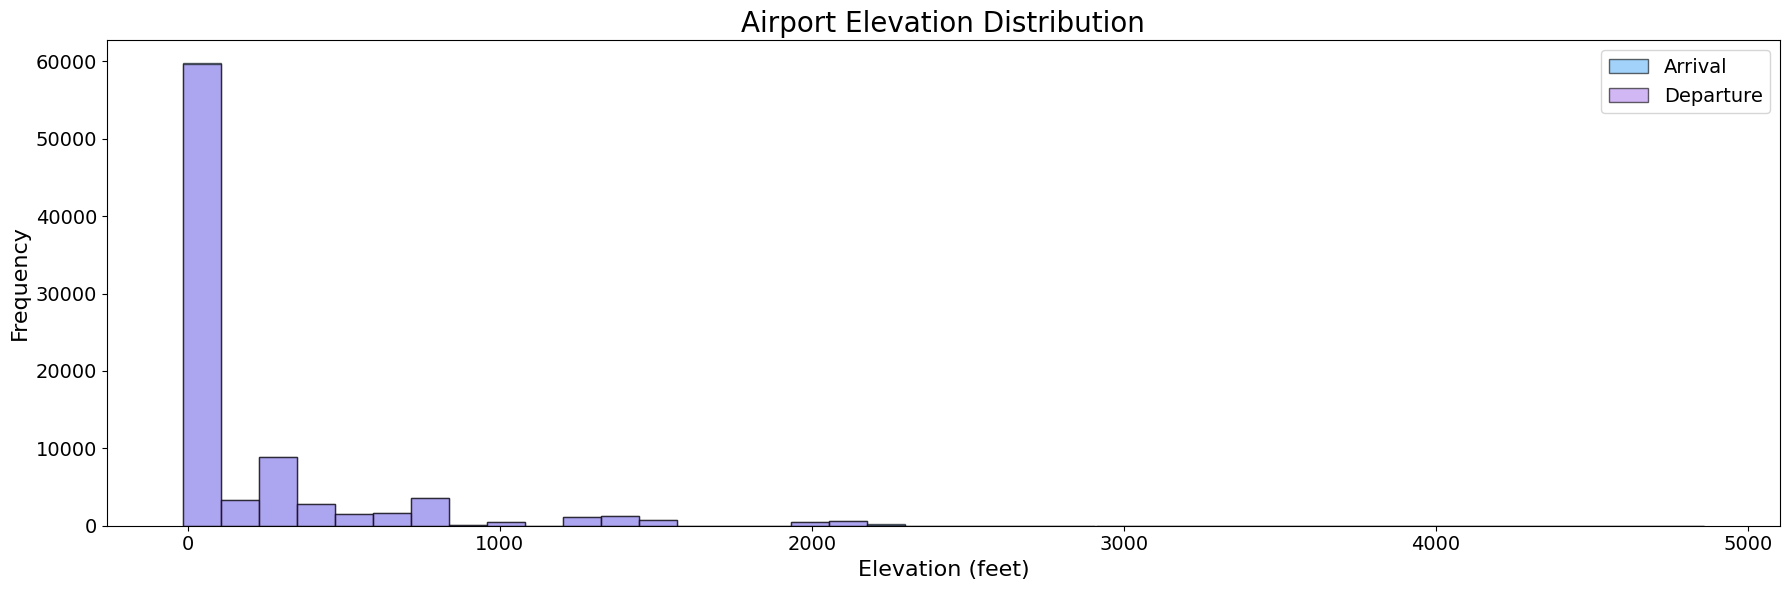

In [207]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (improved visibility)
# ----------------------------

plt.figure(figsize=(18, 6))

# Arrival first (background)
plt.hist(train_df_eda["arr_elevation"], bins=40,
         label="Arrival",
         color="#64B5F6",
         alpha=0.6,
         edgecolor="black",
         zorder=1)

# Departure on top
plt.hist(train_df_eda["dep_elevation"], bins=40,
         label="Departure",
         color="#B388EB",
         alpha=0.6,
         edgecolor="black",
         zorder=2)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


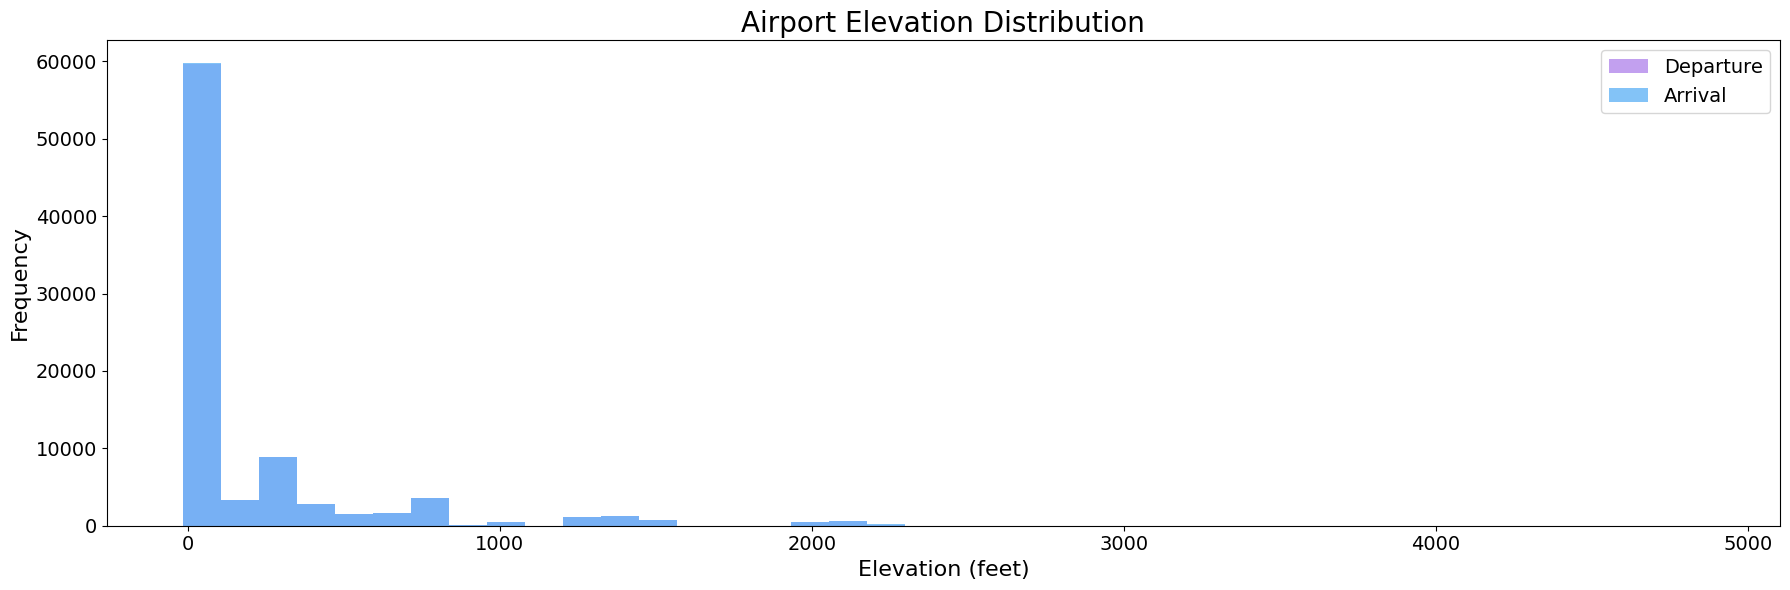

In [208]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (readable version)
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_elevation"], bins=40,
         label="Departure", color="#B388EB", alpha=0.8)

plt.hist(train_df_eda["arr_elevation"], bins=40,
         label="Arrival", color="#64B5F6", alpha=0.8)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

#
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


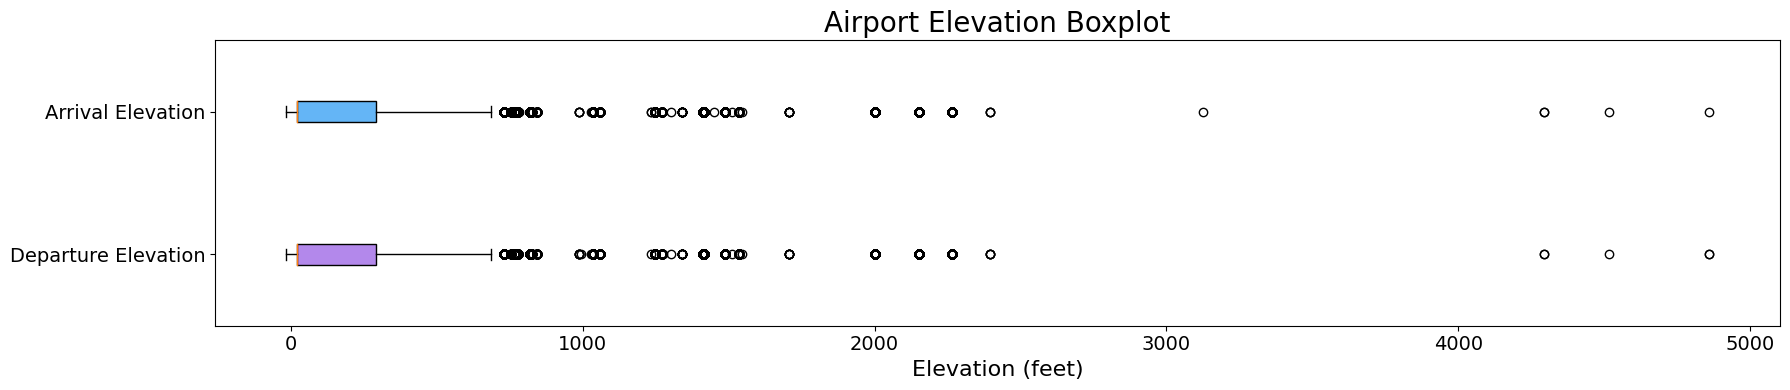

In [209]:
# ----------------------------
# Airport elevation boxplot (two-color version)
# ----------------------------

plt.figure(figsize=(18, 4))

bp = plt.boxplot(
    [train_df_eda["dep_elevation"], train_df_eda["arr_elevation"]],
    vert=False,
    patch_artist=True,
    labels=["Departure Elevation", "Arrival Elevation"]
)

# Set individual box colors
colors = ["#B388EB", "#64B5F6"]  # Purple = Departure, Blue = Arrival

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

plt.title("Airport Elevation Boxplot", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
#plt.xlim(0, 3000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival airport elevations show a strongly right-skewed distribution.  
The majority of flights operate between low-altitude airports (mostly below 1000 feet),  
while a small number of airports appear at much higher elevations (above 3000–5000 feet),  
creating visible outliers in the boxplot.  

The similarity between departure and arrival elevation distributions indicates that  
flight routes in this dataset are not biased toward systematically higher or lower altitude airports.


#### 5.4.3 Geographic Coordinates

✅ Code Cell 1 — Latitude Distribution (Departure vs Arrival)

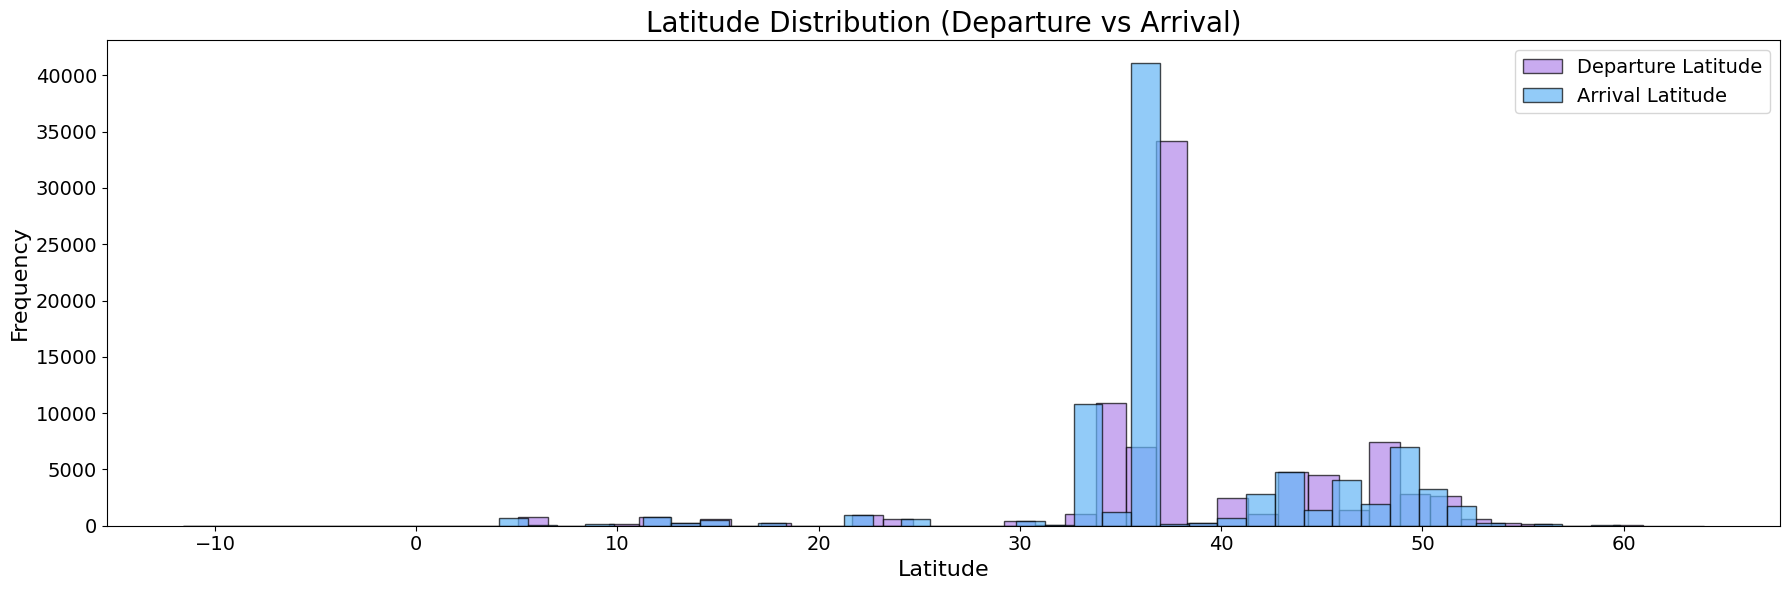

In [210]:
import matplotlib.pyplot as plt

# ----------------------------
# Latitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_lat"], bins=50,
         label="Departure Latitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df_eda["arr_lat"], bins=50,
         label="Arrival Latitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Latitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Latitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


✅ Code Cell 2 — Longitude Distribution (Departure vs Arrival)

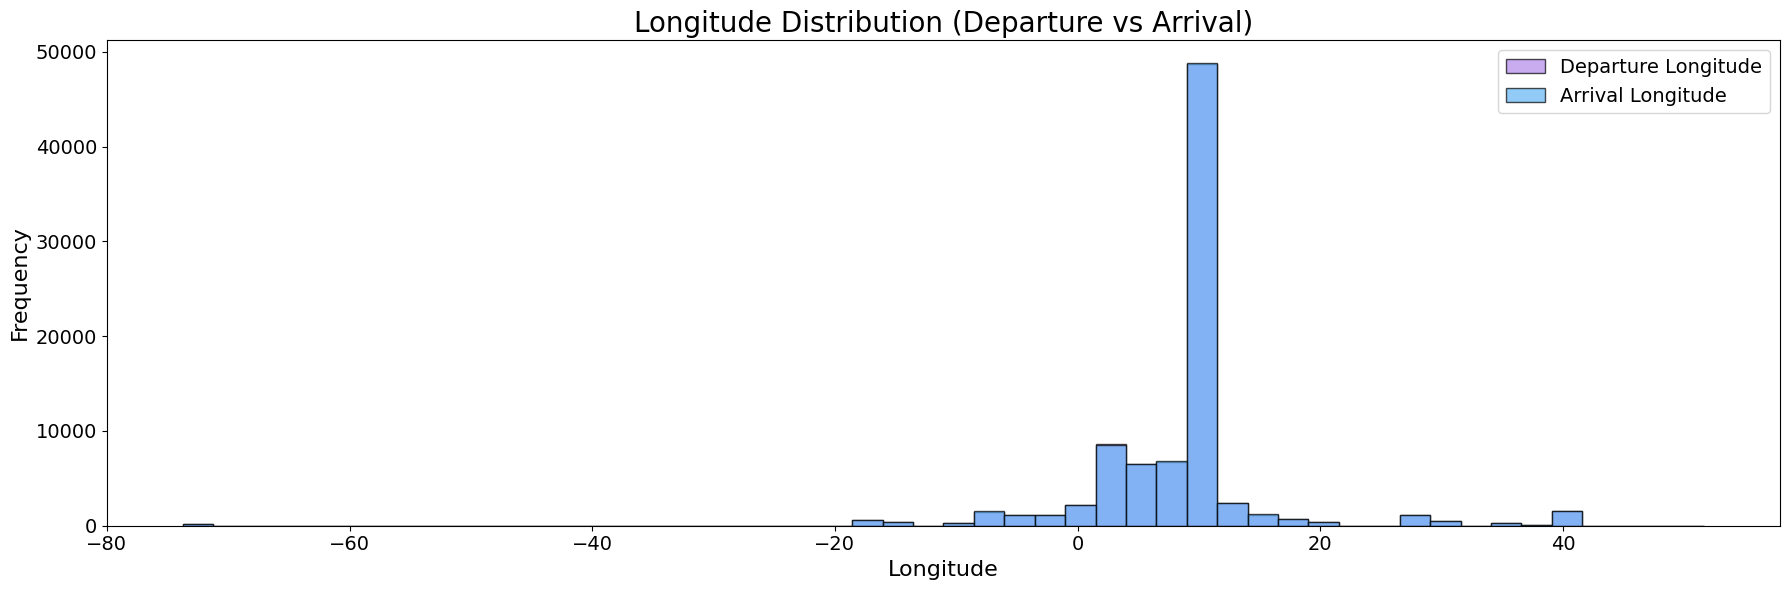

In [211]:
# ----------------------------
# Longitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_lon"], bins=50,
         label="Departure Longitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df_eda["arr_lon"], bins=50,
         label="Arrival Longitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Longitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival latitude distributions are highly concentrated between approximately 30° and 55°, indicating that most flights operate within mid-latitude regions, primarily covering Europe and surrounding areas.  
Longitude values are mainly clustered between approximately -10° and 20°, with smaller secondary clusters extending toward eastern and western longitudes.  
The strong overlap between departure and arrival coordinate distributions suggests similar geographic coverage for origin and destination airports.  
No invalid coordinate ranges are observed (latitude remains within [-90, 90] and longitude within [-180, 180]), indicating that the geographic data is physically consistent.

This geographic concentration is consistent with the operational network of Tunisair, which mainly serves regional and short-to-medium haul routes connecting Tunisia with nearby European and Mediterranean destinations.  
Therefore, the dataset is geographically aligned with the target application domain of the challenge and is suitable for learning location-dependent delay patterns relevant to Tunisair operations.


#### 5.4.4 Time-Based Features

#### 5.4.4.1 Temporal Feature Construction

In [212]:
# ----------------------------
# Central Temporal Feature Construction
# ----------------------------

import pandas as pd

# Parse departure date (DATOP)
train_df_eda["DATOP_dt"] = pd.to_datetime(
    train_df_eda["DATOP"],
    errors="coerce"
)

# Parse scheduled arrival time (STA) with dot-separated time format
train_df_eda["STA_dt"] = pd.to_datetime(
    train_df_eda["STA"],
    format="%Y-%m-%d %H.%M.%S",
    errors="coerce"
)

# Parse scheduled departure time (STD)
train_df_eda["STD_dt"] = pd.to_datetime(
    train_df_eda["STD"],
    errors="coerce"
)

# ----------------------------
# Extract time-based features
# ----------------------------

# Hour of day
train_df_eda["dep_hour"] = train_df_eda["STD_dt"].dt.hour
train_df_eda["arr_hour"] = train_df_eda["STA_dt"].dt.hour

# Day of week
train_df_eda["dep_day"] = train_df_eda["DATOP_dt"].dt.day_name()
train_df_eda["arr_day"] = train_df_eda["STA_dt"].dt.day_name()

# Month
train_df_eda["dep_month"] = train_df_eda["DATOP_dt"].dt.month
train_df_eda["arr_month"] = train_df_eda["STA_dt"].dt.month

# ----------------------------
# Quick sanity check
# ----------------------------

train_df_eda[[
    "STD", "STA",
    "dep_hour", "arr_hour",
    "dep_day", "arr_day",
    "dep_month", "arr_month"
]].head()


,STD,STA,dep_hour,arr_hour,dep_day,arr_day,dep_month,arr_month
30962,2016-11-10 15:25:00,2016-11-10 16.00.00,15,16,Thursday,Thursday,11,11
34625,2017-06-24 16:35:00,2017-06-24 18.05.00,16,18,Saturday,Saturday,6,6
76736,2018-06-03 16:55:00,2018-06-03 19.55.00,16,19,Sunday,Sunday,6,6
52580,2017-08-18 00:35:00,2017-08-18 05.10.00,0,5,Friday,Friday,8,8
97130,2018-12-09 15:00:00,2018-12-09 16.25.00,15,16,Sunday,Sunday,12,12


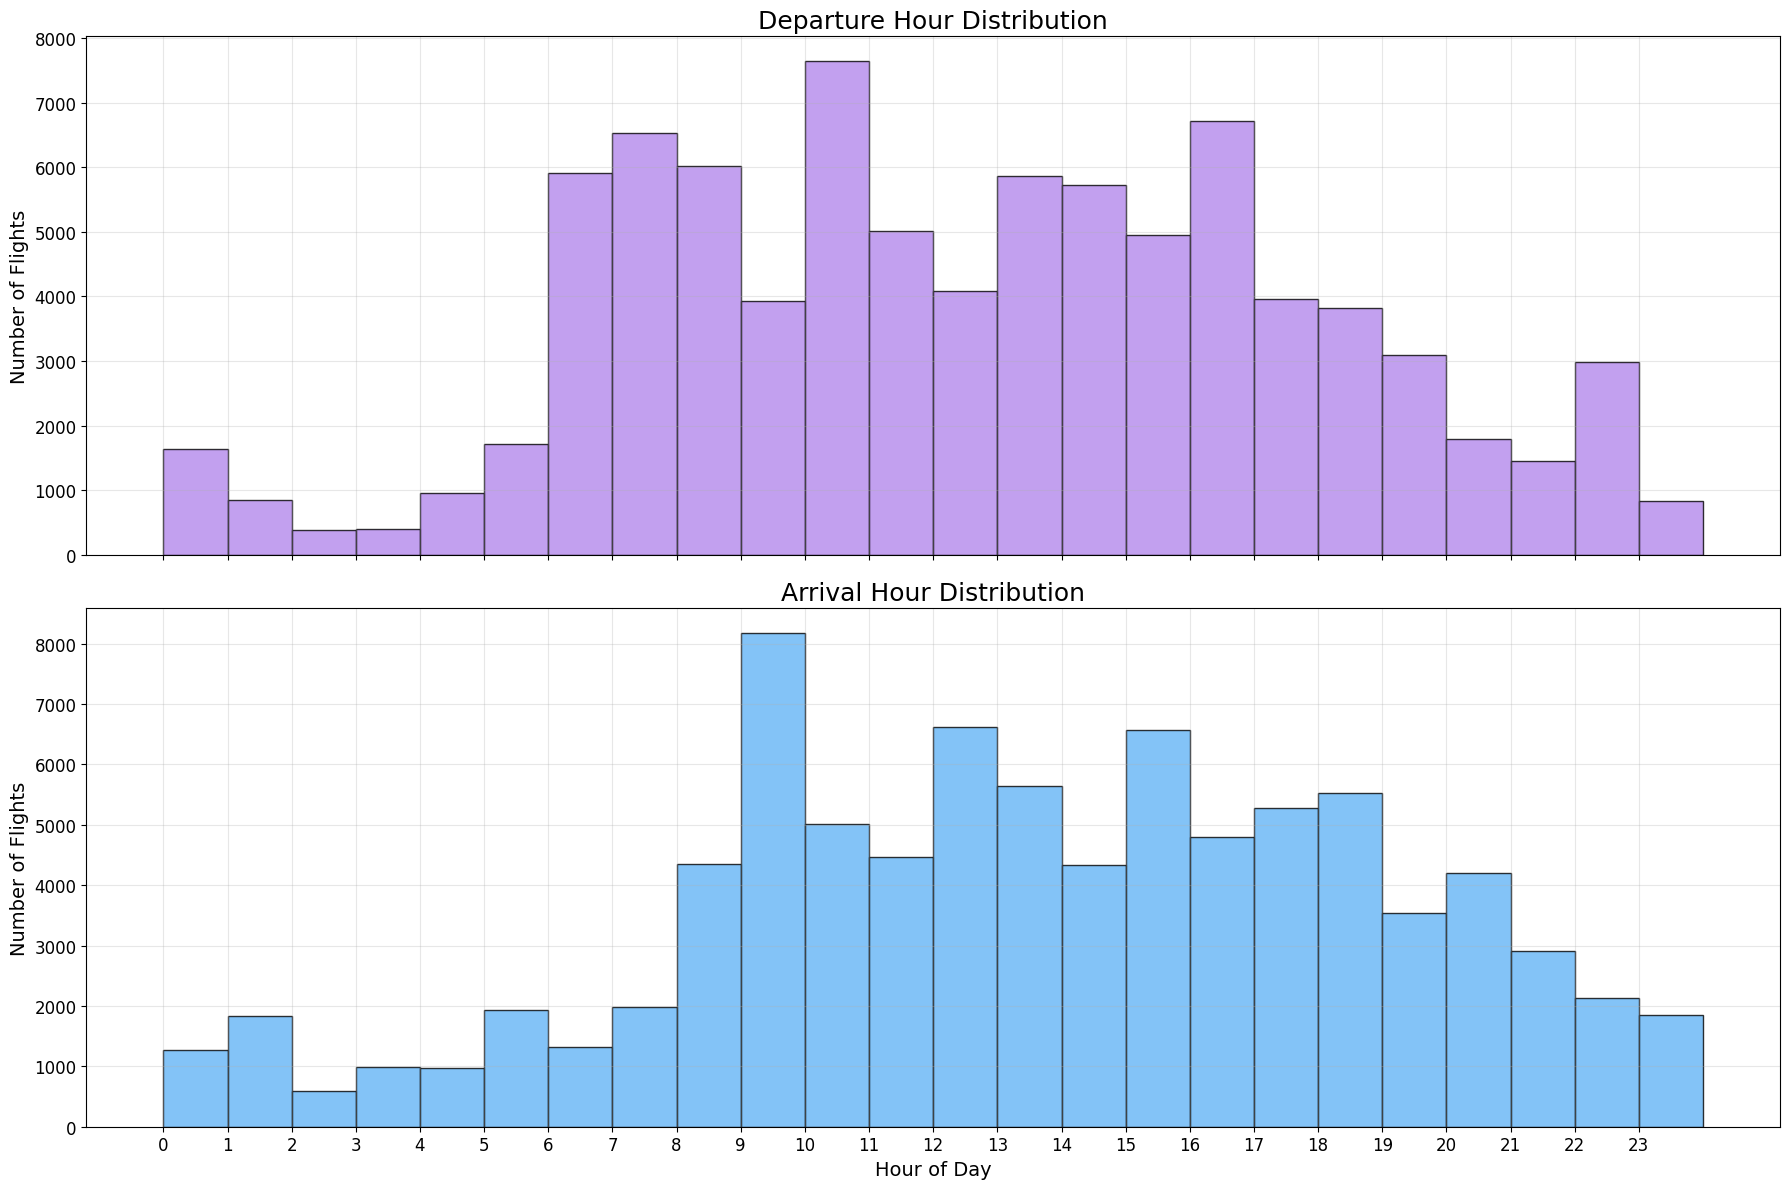

In [213]:

# ----------------------------
# Hour of day distribution (Departure vs Arrival)
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure hour
axes[0].hist(
    train_df_eda["dep_hour"].dropna(),
    bins=24,
    range=(0, 24),
    color="#B388EB",
    alpha=0.8,
    edgecolor="black"
)

axes[0].set_title("Departure Hour Distribution", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival hour
axes[1].hist(
    train_df_eda["arr_hour"].dropna(),
    bins=24,
    range=(0, 24),
    color="#64B5F6",
    alpha=0.8,
    edgecolor="black"
)

axes[1].set_title("Arrival Hour Distribution", fontsize=18)
axes[1].set_xlabel("Hour of Day", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival flights show strong concentration during daytime operational hours, with clear peaks in the morning and afternoon periods.
Most flights are scheduled during daytime hours.
Departure and arrival activity peaks in the morning (around 7–10) and again in the afternoon (around 14–17).
Very few flights operate during late night and early morning hours (0–5), indicating limited overnight operations.
This pattern reflects typical airline scheduling behavior and indicates that time-of-day may be an important temporal feature for modeling delay dynamics.

##### - Day of Week Distribution (Departure vs Arrival)

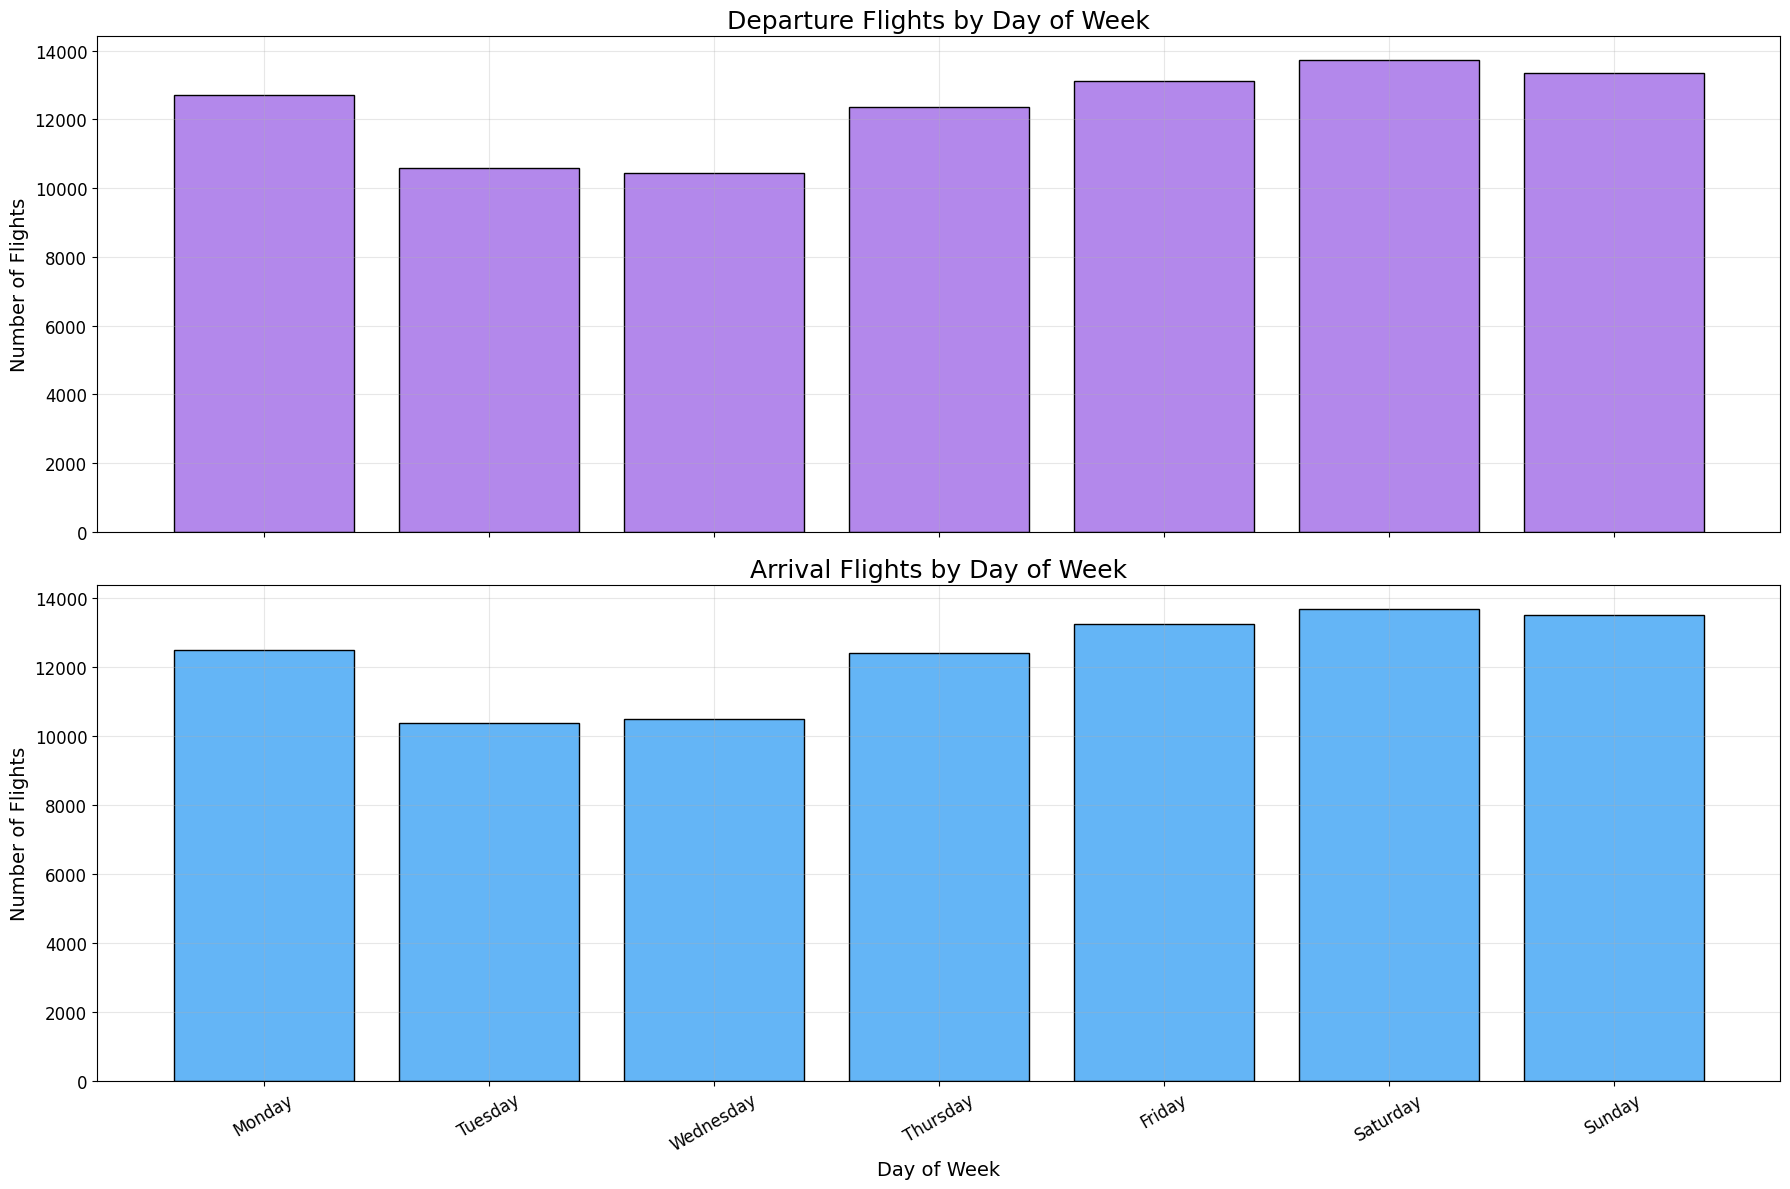

In [214]:

# ----------------------------
# Day of week distribution (Departure vs Arrival)
# ----------------------------

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

dep_counts = train_df_eda["dep_day"].value_counts().reindex(day_order)
arr_counts = train_df_eda["arr_day"].value_counts().reindex(day_order)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(day_order, dep_counts,
            color="#B388EB", edgecolor="black")

axes[0].set_title("Departure Flights by Day of Week", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival
axes[1].bar(day_order, arr_counts,
            color="#64B5F6", edgecolor="black")

axes[1].set_title("Arrival Flights by Day of Week", fontsize=18)
axes[1].set_xlabel("Day of Week", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Observation**

Flight volume is relatively stable across the week, with slightly lower activity on Tuesday and Wednesday.
The highest number of both departures and arrivals occurs during the weekend, especially on Saturday and Sunday, indicating increased travel demand toward the end of the week.

##### - Monthly Distribution (Departure vs Arrival)


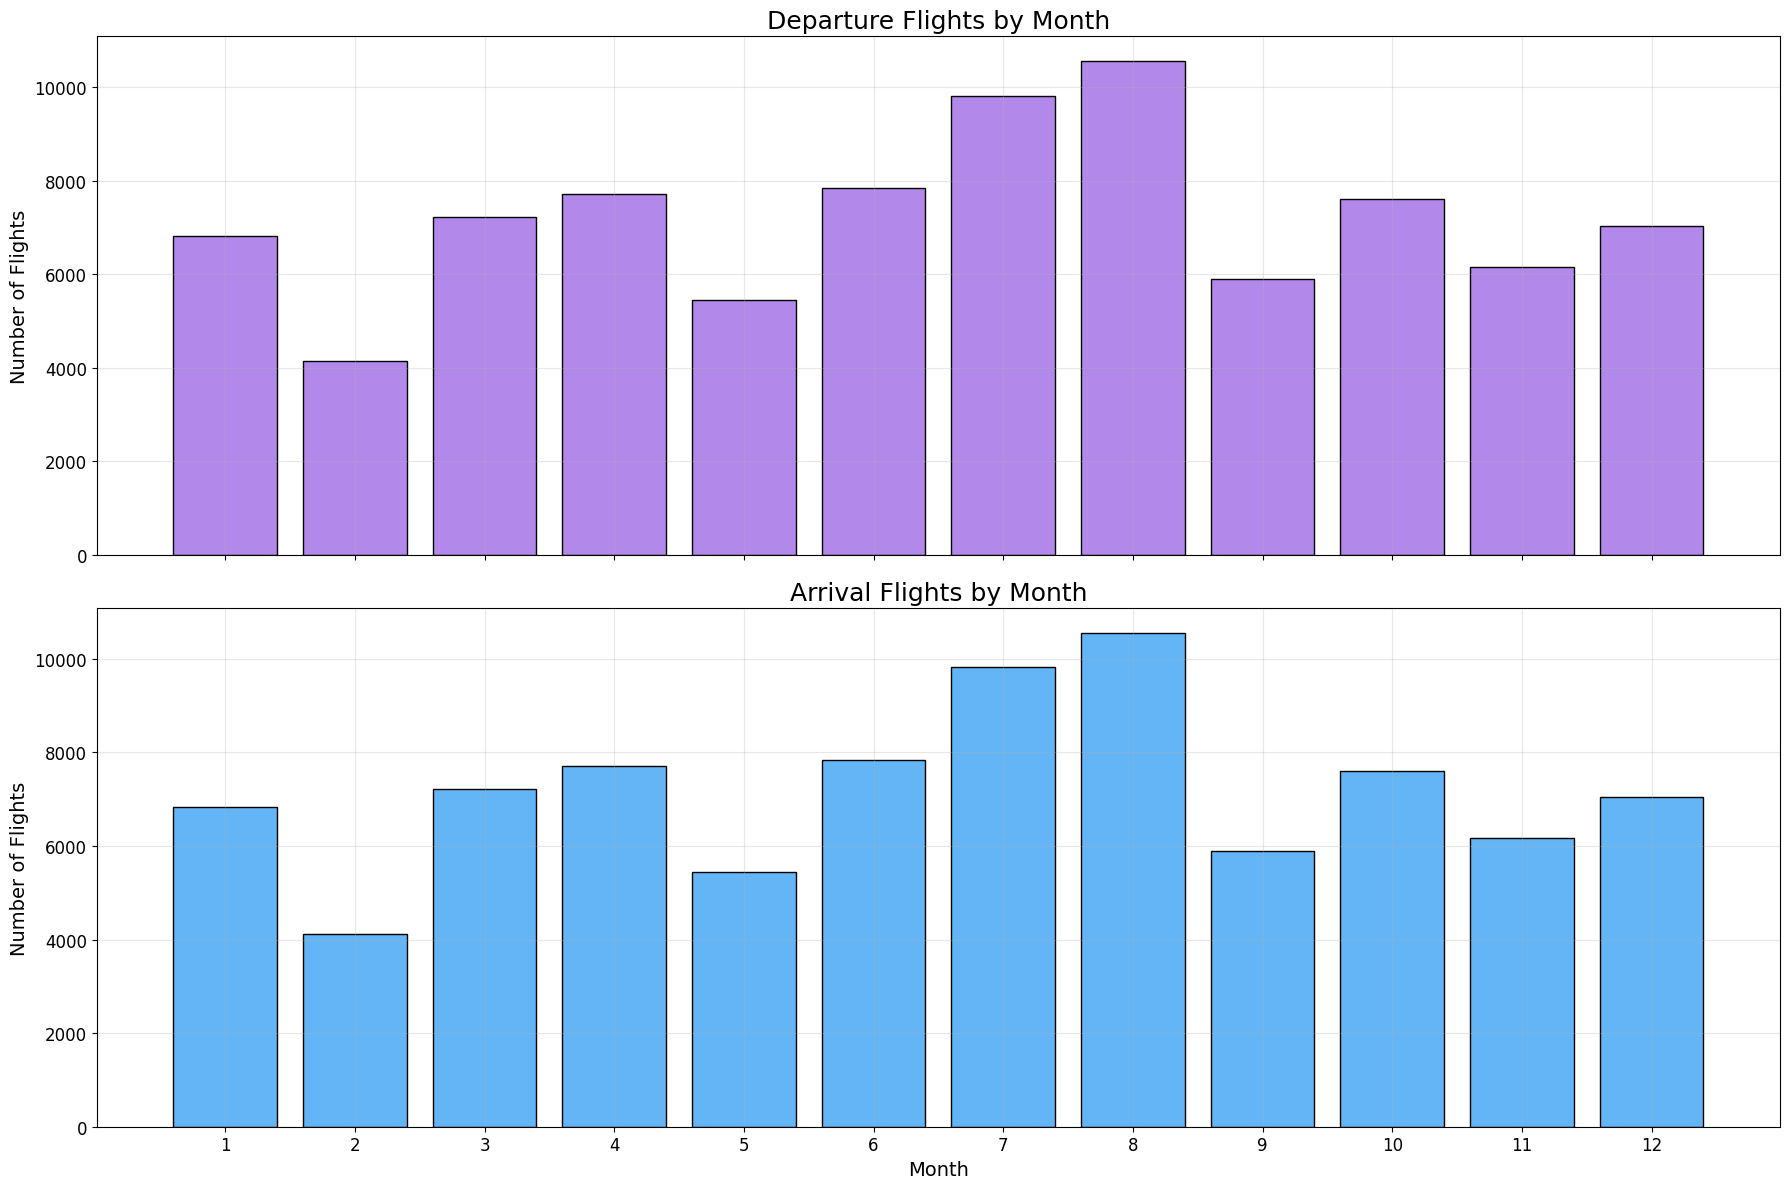

In [215]:

# ----------------------------
# Monthly distribution (Departure vs Arrival)
# ----------------------------

months = range(1, 13)

dep_month_counts = (
    train_df_eda["dep_month"]
    .value_counts()
    .sort_index()
    .reindex(months)
)

arr_month_counts = (
    train_df_eda["arr_month"]
    .value_counts()
    .sort_index()
    .reindex(months)
)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(
    months,
    dep_month_counts,
    color="#B388EB",
    edgecolor="black"
)

axes[0].set_title("Departure Flights by Month", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival
axes[1].bar(
    months,
    arr_month_counts,
    color="#64B5F6",
    edgecolor="black"
)

axes[1].set_title("Arrival Flights by Month", fontsize=18)
axes[1].set_xlabel("Month", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(months)
plt.tight_layout()
plt.show()



**Observation**

Both departure and arrival flight volumes show clear seasonal patterns.
Flight activity is lowest in February and May, while peak volumes occur during summer months, especially July and August.

This seasonal trend is consistent with increased travel demand during the summer holiday period and indicates that month-of-year is a meaningful temporal feature for capturing demand-driven delay patterns.

### 5.5 Distribution Analysis (Categorical Features)

#### 5.5.1 Flight Status Distribution

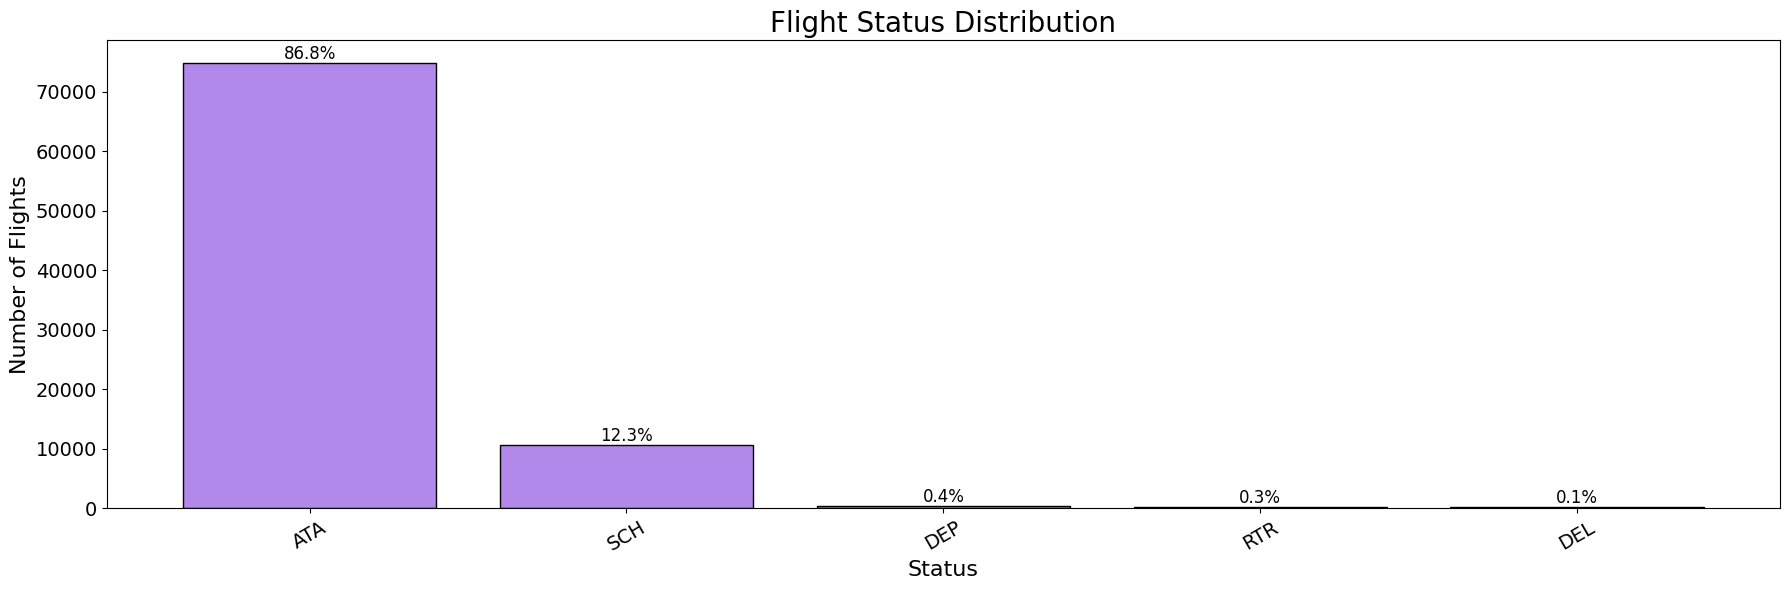

In [216]:

# ----------------------------
# Flight status distribution with percentage labels
# ----------------------------

status_counts = train_df_eda["STATUS"].value_counts()
total_count = status_counts.sum()

plt.figure(figsize=(18, 6))

bars = plt.bar(
    status_counts.index,
    status_counts.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Flight Status Distribution", fontsize=20)
plt.xlabel("Status", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


**Observation — Flight Status Distribution**

The majority of flights are labeled as ATA (~87%), indicating that most records correspond to successfully completed flights with recorded arrival times.
A smaller but still significant portion is labeled as SCH (~12%), which likely represents scheduled flights without confirmed arrival timestamps.

The remaining categories (DEP, RTR, DEL) each account for less than 1% of the dataset and represent rare operational events such as partial departures, returns to gate, or major disruptions.

Likely interpretation of status codes:

ATA (Actual Time of Arrival): Completed flights with recorded arrival time

SCH (Scheduled): Flights planned but without confirmed arrival record

DEP (Departed): Flights that departed but lack arrival information

RTR (Return to Ramp/Gate): Flights that returned to gate after pushback or taxi

DEL (Delayed/Cancelled): Flights with major operational disruption (delay or cancellation)

⚠️ Data Leakage Consideration:
The STATUS variable may contain post-event operational information that is not available at prediction time.
Using this feature directly for delay prediction could introduce data leakage and artificially inflate model performance.
Therefore, this variable should be carefully evaluated or excluded during the modeling phase.

#### 5.5.2 Aircraft Type Distribution (AC)

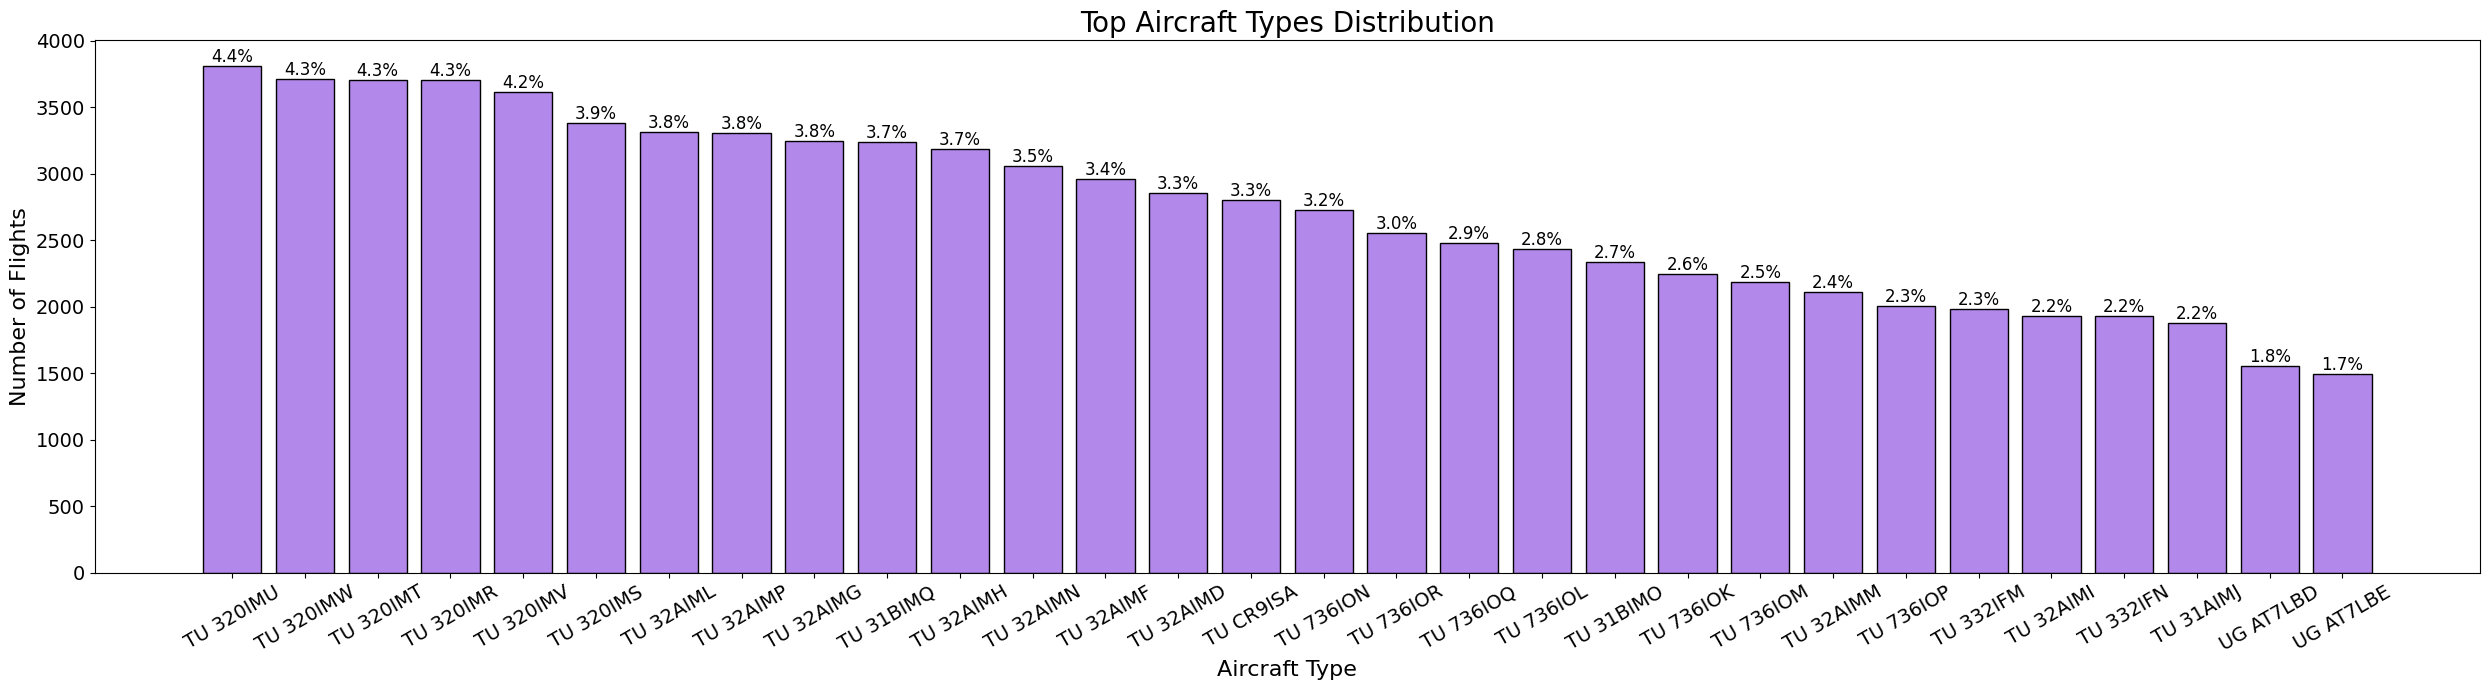

In [217]:
import matplotlib.pyplot as plt

# ----------------------------
# Aircraft type distribution
# ----------------------------

ac_counts = train_df_eda["AC"].value_counts()
ac_percent = ac_counts / ac_counts.sum() * 100

# Take top 30 aircraft types for readability
top_n = 30
ac_counts_top = ac_counts.head(top_n)
ac_percent_top = ac_percent.head(top_n)

plt.figure(figsize=(25, 7))

bars = plt.bar(
    ac_counts_top.index,
    ac_counts_top.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Top Aircraft Types Distribution", fontsize=20)
plt.xlabel("Aircraft Type", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar, pct in zip(bars, ac_percent_top):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [218]:
print(train_df_eda["AC"].unique().shape)
train_df_eda["AC"].unique()

(68,)


array(['UG AT7AT7', 'TU 320IMS', 'TU 32AIMD', 'TU 320IMU', 'TU 31BIMQ',
       '5K 345TFX', 'TU CR9ISA', 'TU 32AIMP', 'TU 736ION', 'UG AT7LBE',
       'TU 32AIMI', 'TU 736IOK', 'TU 32AIMC', 'TU 32AIMF', 'TU 31BIMO',
       '5K 343TQY', 'TU 31AIMJ', 'TU 332IFN', 'TU 332IFM', 'TU 320IMW',
       'TU 32AIMM', 'TU 320IMV', 'PS 738PSD', 'TU 736IOL', 'TU 320IMT',
       'TU 32AIML', 'TU 736IOP', 'TU 32AIMN', 'TU 320IMR', 'TU 736IOR',
       'TU 32AIMH', 'TU 736IOM', 'TU 736IOQ', 'GJ 733LGC', 'TU 32AIMG',
       'UG CR9XXX', 'TU 31AIMK', 'UG AT7LBD', 'D4 319CQG', '5M 343FOX',
       '5M 343SUN', 'GJ 733GGC', 'D4 320CQP', 'UG CR9CR9', 'GJ 734PGC',
       'GJ 733EWE', 'BJ 320INP', 'UG CR9ISA', 'GJ 734MGC', 'QS 738TSC',
       'GJ 734CGC', '5M 343JAI', 'UJ 320TCF', 'BJ 320INO', 'BJ 320INC',
       'GW 320MQH', 'BJ 320INA', 'BJ 320INB', 'X9 320VEB', 'BJ 320INQ',
       '6P M87TRJ', 'BJ 320INR', 'BJ 320INH', 'TU 320320', 'TU CR9XXX',
       'TU CR9CR9', 'OL 321ABY', 'TU 32A32A'], dtype=object)

In [219]:
train_df_eda["AC"].value_counts().head(10)

AC
TU 320IMU    3811
TU 320IMW    3710
TU 320IMT    3707
TU 320IMR    3705
TU 320IMV    3610
TU 320IMS    3377
TU 32AIML    3309
TU 32AIMP    3307
TU 32AIMG    3245
TU 31BIMQ    3234
Name: count, dtype: int64

In [220]:
(train_df_eda["AC"].value_counts(normalize=True) * 100).round(2).head(10)

AC
TU 320IMU    4.42
TU 320IMW    4.30
TU 320IMT    4.30
TU 320IMR    4.29
TU 320IMV    4.18
TU 320IMS    3.91
TU 32AIML    3.84
TU 32AIMP    3.83
TU 32AIMG    3.76
TU 31BIMQ    3.75
Name: proportion, dtype: float64

**Observation — Aircraft Type (AC)**

The aircraft type distribution is relatively spread across many categories, with approximately 68 distinct aircraft identifiers present in the dataset.
No single aircraft type dominates the dataset: the most frequent model accounts for only about 4.4% of all flights, and even the top 10 aircraft types each contribute less than 5% individually.

This indicates a high-cardinality categorical feature with moderate class imbalance and a long tail of less frequent aircraft types.
Such a distribution may require careful encoding strategies (for example grouping rare categories or using target/frequency encoding) during modeling to avoid sparsity and overfitting.

The aircraft identifier (AC) may indirectly encode operational or historical patterns.
Therefore, special care must be taken to ensure that feature engineering and encoding are performed only on training data and without using future information from the test set.

#### 5.5.3 Departure Country Distribution

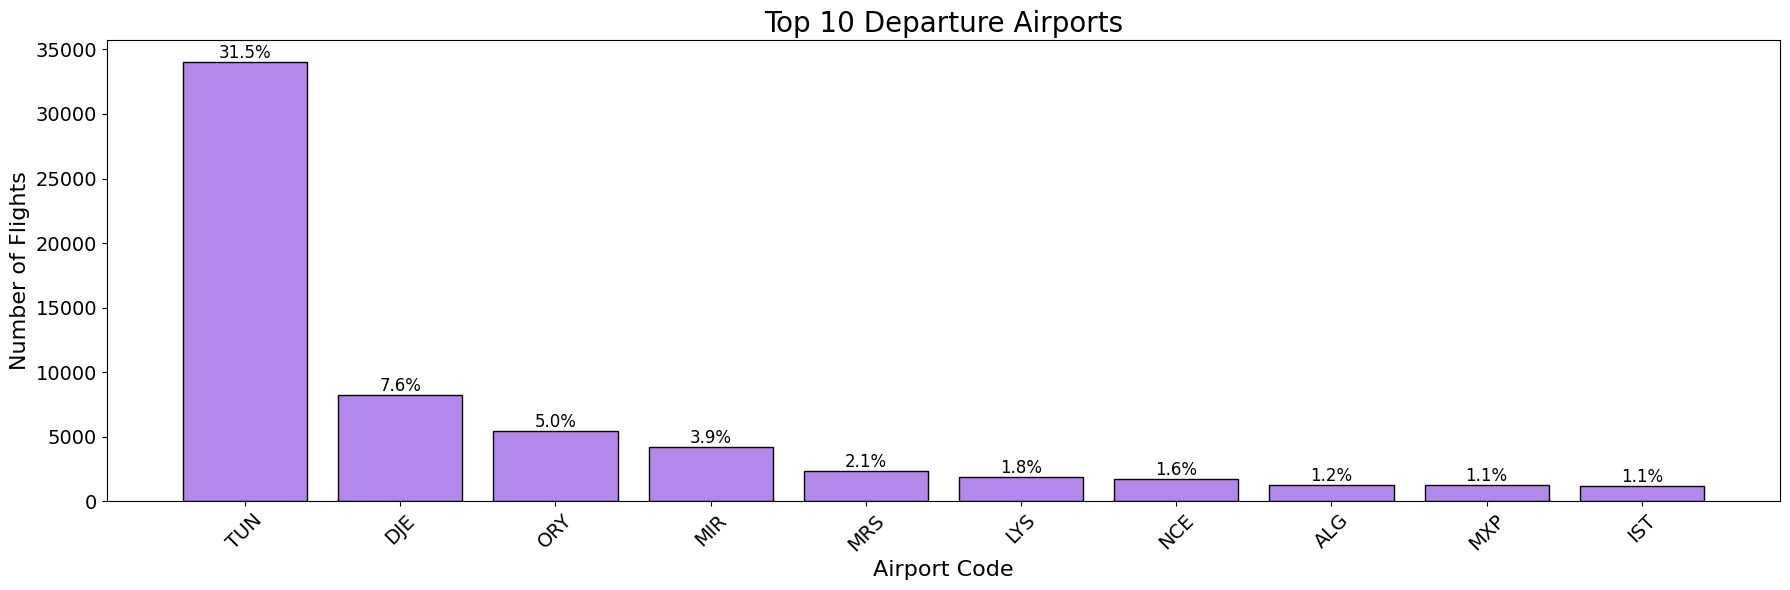

In [221]:
# ----------------------------
# Top Departure Airports
# ----------------------------

top_dep = train_df_eda["DEPSTN"].value_counts().head(10)

plt.figure(figsize=(18, 6))

bars = plt.bar(
    top_dep.index,
    top_dep.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Top 10 Departure Airports", fontsize=20)
plt.xlabel("Airport Code", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels
total_flights = len(train_df)

for bar in bars:
    height = bar.get_height()
    percent = height / total_flights * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [222]:
print(train_df_eda["DEPSTN"].unique().shape)
train_df["DEPSTN"].unique()


(125,)


array(['CMN', 'MXP', 'TUN', 'DJE', 'TLS', 'IST', 'ORY', 'MIR', 'BRU',
       'ABJ', 'VCE', 'AMS', 'FRA', 'BCN', 'JED', 'ALG', 'LIS', 'SXB',
       'LYS', 'OUA', 'LGW', 'BEY', 'NCE', 'OPO', 'MRS', 'DUS', 'SFA',
       'FCO', 'CDG', 'NKC', 'NTE', 'ZRH', 'GVA', 'OUD', 'MUC', 'BER',
       'HAM', 'NDR', 'NBE', 'CAI', 'BEG', 'VIE', 'ORN', 'MAD', 'TOE',
       'BKO', 'DKR', 'KGL', 'BLQ', 'MLA', 'AHU', 'LHR', 'BOD', 'PRG',
       'LJU', 'SVO', 'MED', 'BUD', 'ARN', 'CPH', 'CRL', 'OST', 'TNG',
       'GAF', 'NAP', 'BRQ', 'OSR', 'YUL', 'NIM', 'TMR', 'JIB', 'CGN',
       'EBL', 'GAE', 'BJA', 'AYT', 'RAK', 'LFW', 'LIL', 'PMO', 'FBM',
       'TBJ', 'PSA', 'KRT', 'GNB', 'CZL', 'MVB', 'VNO', 'ESB', 'LBV',
       'CKY', 'LED', 'KSC', 'BTS', 'AMM', 'OTP', 'TRN', 'IEV', 'HBE',
       'CAG', 'KBP', 'ATH', 'SKG', 'ADB', 'DSS', 'DOH', 'COO', 'LUX',
       'FIH', 'BYJ', 'KEF', 'EBM', 'BDS', 'AAL', 'VKO', 'AAE', 'BRI',
       'VRN', 'SKX', 'HAJ', 'BLL', 'TLL', 'VOG', 'LAD', 'GHA', 'KTW',
       'SJJ', 'KRR',

#### 5.5.4 Arrival Country Distribution

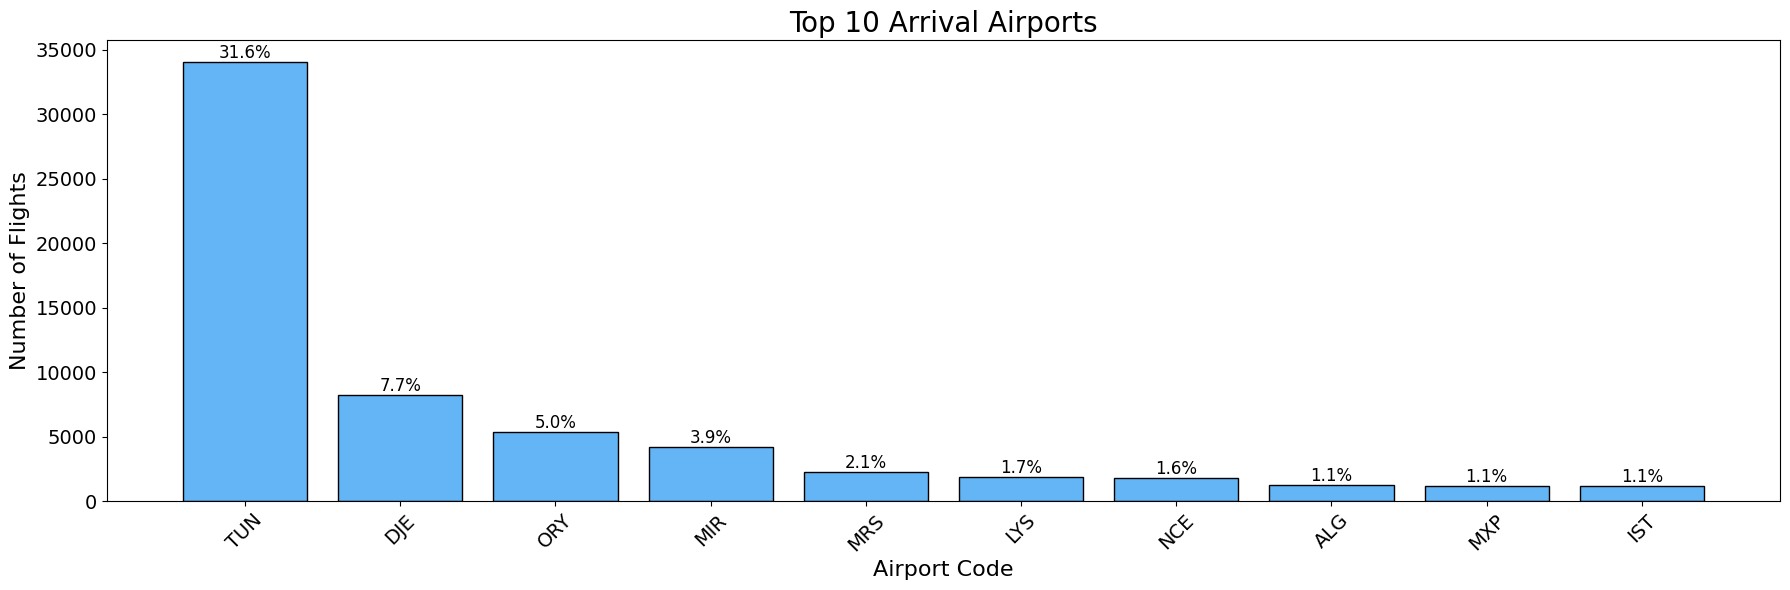

In [223]:
# ----------------------------
# Top Arrival Airports
# ----------------------------

top_arr = train_df_eda["ARRSTN"].value_counts().head(10)

plt.figure(figsize=(18, 6))

bars = plt.bar(
    top_arr.index,
    top_arr.values,
    color="#64B5F6",
    edgecolor="black"
)

plt.title("Top 10 Arrival Airports", fontsize=20)
plt.xlabel("Airport Code", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    percent = height / total_flights * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [224]:
print(train_df_eda["ARRSTN"].unique().shape)
train_df_eda["ARRSTN"].unique()

(127,)


array(['GAE', 'TUN', 'MIR', 'FCO', 'GVA', 'DJE', 'ALG', 'MUC', 'ORN',
       'LYS', 'COO', 'DKR', 'ORY', 'NKC', 'NCE', 'CAI', 'NTE', 'JED',
       'BEG', 'SFA', 'BRQ', 'ABJ', 'CMN', 'VCE', 'BRU', 'VIE', 'CDG',
       'OUA', 'IST', 'TOE', 'BER', 'AMS', 'LED', 'DSS', 'NIM', 'BCN',
       'DUS', 'FRA', 'LGW', 'SXB', 'MRS', 'PRG', 'TLS', 'NBE', 'MAD',
       'BOD', 'OUD', 'HAM', 'LHR', 'NAP', 'MXP', 'BKO', 'BEY', 'CKY',
       'ZRH', 'MED', 'NDR', 'VKO', 'BUD', 'BLQ', 'LIS', 'YUL', 'EBL',
       'OST', 'ARN', 'SVO', 'GAF', 'MLA', 'PMO', 'CPH', 'ESB', 'CZL',
       'HAJ', 'RTM', 'HBE', 'ATH', 'CGN', 'OSR', 'BTS', 'OPO', 'LIL',
       'BJA', 'LJU', 'TRN', 'TBJ', 'IEV', 'AHU', 'VNO', 'KSC', 'CAG',
       'VRN', 'TNG', 'CRL', 'SJJ', 'EBM', 'AYT', 'AMM', 'FIH', 'BYJ',
       'BLL', 'KBP', 'OTP', 'GNB', 'CTA', 'PSA', 'SKG', 'JIB', 'SKX',
       'FBM', 'TPS', 'LBV', 'LFW', 'LUX', 'BRI', 'AAE', 'TMR', 'GHA',
       'VOG', 'BDS', 'BGY', 'LAD', 'DOH', 'RAK', 'MVB', 'ADB', 'KGL',
       'KRT'], dtype

**Observation — Top Departure and Arrival Airports**

Tunis-Carthage Airport (TUN) clearly dominates both departure and arrival traffic, accounting for roughly 40% of all flights.
This confirms that TUN acts as the main operational hub for Tunisair.

The remaining top airports (such as DJE, ORY, MIR, MRS) have significantly smaller shares, each contributing less than 10% individually.
This indicates a hub-and-spoke structure, where most routes are centered around Tunis with secondary connections to major regional and European airports.

The similarity between the top departure and arrival airport distributions suggests a balanced inbound and outbound traffic pattern, which is expected for scheduled airline operations.

This strong concentration should be considered during modeling, as airport-specific patterns (especially for TUN) may have a strong influence on delay behavior.


### 5.6 Feature Relationship Analysis (Feature–Feature)

#### 5.6.1 Numerical Feature Correlation Analysis

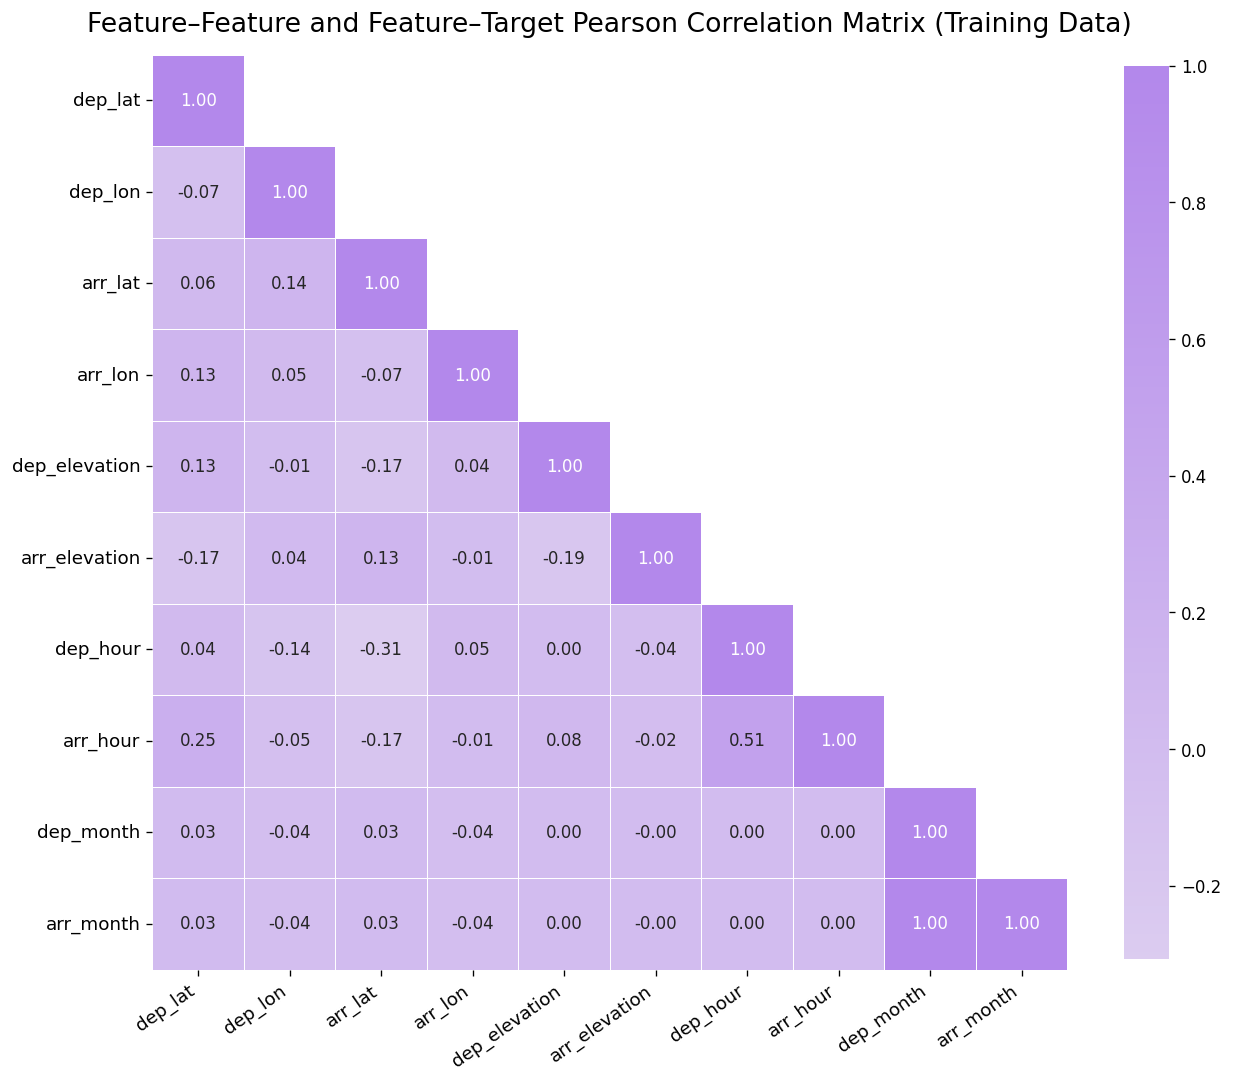

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Correlation matrix
# ----------------------------

num_cols = [
    "dep_lat", "dep_lon",
    "arr_lat", "arr_lon",
    "dep_elevation", "arr_elevation",
    "dep_hour", "arr_hour",
    "dep_month", "arr_month"
]

corr = train_df_eda[num_cols].corr()

# Mask upper triangle (keep lower half only)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Purple theme (your project color)
cmap = sns.light_palette("#B388EB", as_cmap=True)

# ----------------------------
# Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(11, 10), dpi=120)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,              # KEEP NUMBERS ✅
    fmt=".2f",
    annot_kws={"size": 10},  # bigger numbers (readable)
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# Clean borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

ax.set_title(
    "Feature–Feature and Feature–Target Pearson Correlation Matrix (Training Data)",
    fontsize=16,
    pad=14
)

plt.tight_layout()
plt.show()

**Observation**

The correlation matrix shows generally low pairwise correlations among most numerical features, indicating limited multicollinearity.

A moderate positive correlation (~0.51) is observed between departure hour and arrival hour, which is expected due to scheduled flight durations and daily traffic patterns.

Departure month and arrival month exhibit perfect correlation (1.00), confirming that both features carry identical temporal information. Therefore, only one of them should be retained for modeling.

Geographic coordinates (latitude and longitude) and elevation features show weak correlations with other variables, suggesting that they provide largely independent spatial and environmental information.

Overall, the numerical feature set appears suitable for modeling with minimal redundancy after removing duplicated temporal features.

**Note on Time Zones**

Departure and arrival time-based features (hour of day, day of week) are currently extracted using local airport times.

This design choice is intentional, as local time patterns capture operational effects such as peak-hour congestion and daily scheduling behavior.

For duration-based or cross-airport temporal features, time zone normalization using airport time zone information (dep_tz, arr_tz) may be required and will be considered during the feature engineering phase.


### 5.6.2 Redundant Feature Check (Semantic Overlap)

Several feature pairs exhibit strong semantic overlap due to the way they were constructed from the same underlying information sources:

- **dep_month and arr_month**  
  These two features are perfectly correlated (correlation = 1.00) because most flights occur within the same calendar month for both departure and arrival. Keeping both does not add new information and introduces full redundancy.

- **dep_hour and arr_hour**  
  These features show moderate correlation (~0.51), which is expected since arrival times are naturally linked to departure times through flight schedules. However, they are not identical and may still capture different operational patterns (e.g., departure congestion vs arrival congestion).

- **Geographic coordinate pairs (dep_lat vs arr_lat, dep_lon vs arr_lon)**  
  While not strongly correlated numerically, these pairs represent symmetric spatial information about route endpoints. They are semantically related but still provide complementary information about route geometry.

Based on this analysis, redundant or highly overlapping features will be handled during the feature selection and modeling phase to avoid multicollinearity and unnecessary feature duplication.


### 5.6.3 Multicollinearity Diagnostic (Preparation Step)

At this stage, multicollinearity is assessed qualitatively based on correlation patterns and semantic feature overlap.

Strongly related feature pairs such as duplicated temporal variables (e.g., departure and arrival month) and partially dependent time features (e.g., departure and arrival hour) are flagged as potential multicollinearity sources.

A formal multicollinearity diagnostic using Variance Inflation Factor (VIF) will be performed later during the modeling phase after feature preprocessing and encoding steps have been applied.

### 5.7 Feature–Target Relationship Analysis

#### 5.7.1 Correlation Matrix (Numerical Features vs Target)

In [226]:
train_df_eda.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city', 'dep_subd',
       'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon', 'dep_tz',
       'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city', 'arr_subd',
       'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon', 'arr_tz',
       'arr_lid', 'target', 'DATOP_dt', 'STA_dt', 'STD_dt', 'dep_hour',
       'arr_hour', 'dep_day', 'arr_day', 'dep_month', 'arr_month'],
      dtype='object')

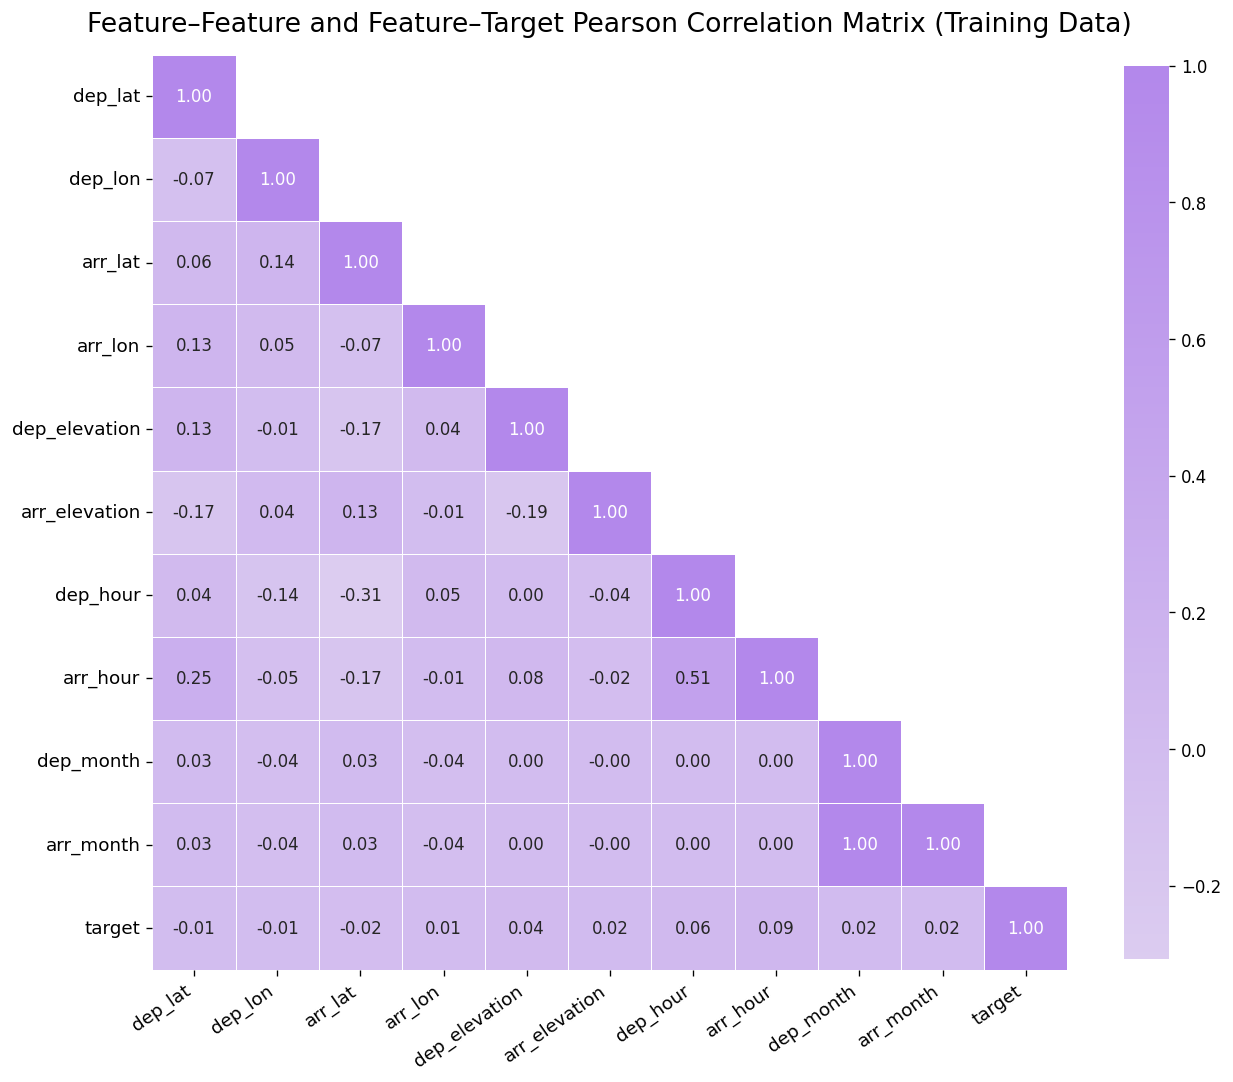

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Correlation matrix
# ----------------------------

num_cols = [
    "dep_lat", "dep_lon",
    "arr_lat", "arr_lon",
    "dep_elevation", "arr_elevation",
    "dep_hour", "arr_hour",
    "dep_month", "arr_month",
    "target"
]

corr = train_df_eda[num_cols].corr()

# Mask upper triangle (keep lower half only)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Purple theme (your project color)
cmap = sns.light_palette("#B388EB", as_cmap=True)

# ----------------------------
# Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(11, 10), dpi=120)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,              # KEEP NUMBERS ✅
    fmt=".2f",
    annot_kws={"size": 10},  # bigger numbers (readable)
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# Clean borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

ax.set_title(
    "Feature–Feature and Feature–Target Pearson Correlation Matrix (Training Data)",
    fontsize=16,
    pad=14
)

plt.tight_layout()
plt.show()


#### 5.7.2 Delay vs Time-Based Features

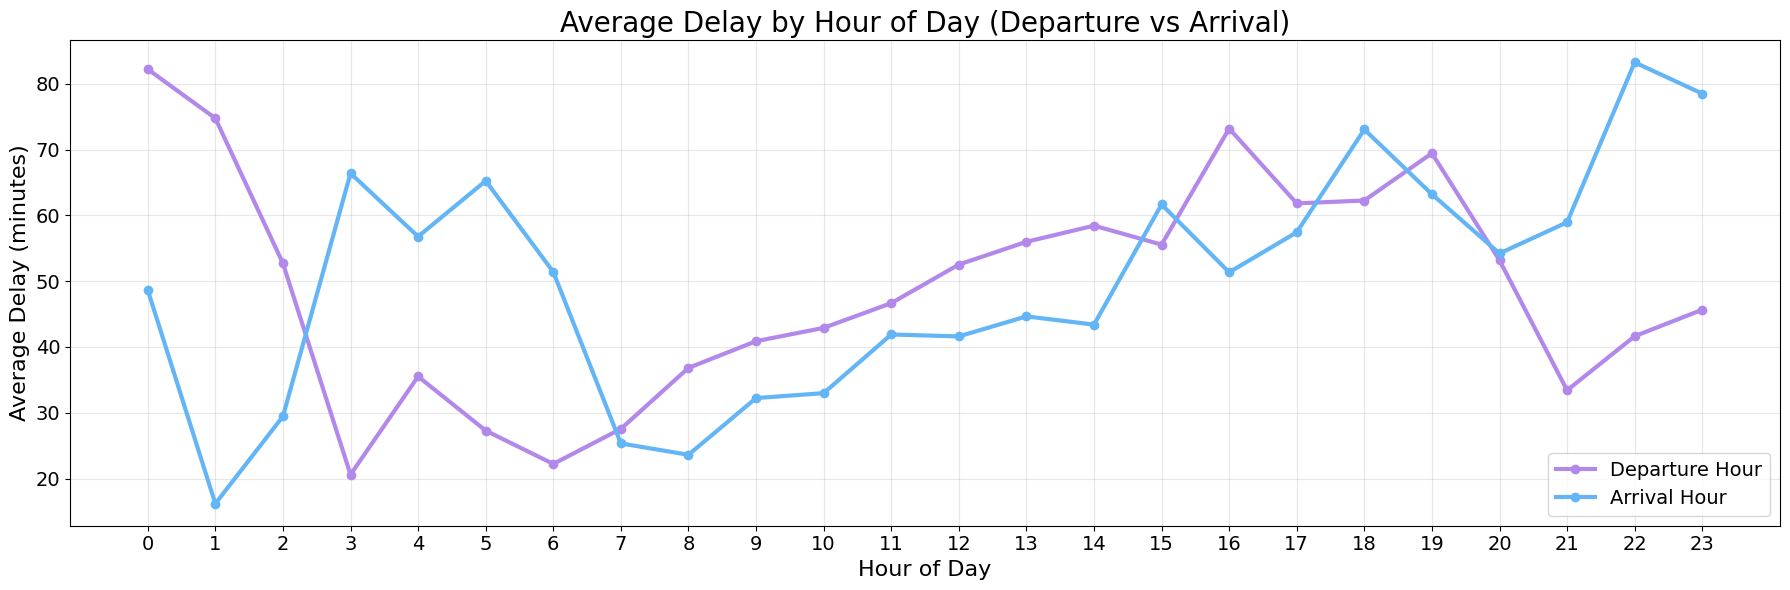

In [228]:
# ----------------------------
# Average delay by departure hour vs arrival hour
# ----------------------------

avg_delay_dep_hour = (
    train_df_eda
    .groupby("dep_hour")["target"]
    .mean()
)

avg_delay_arr_hour = (
    train_df_eda
    .groupby("arr_hour")["target"]
    .mean()
)

plt.figure(figsize=(18, 6))

# Departure line
plt.plot(
    avg_delay_dep_hour.index,
    avg_delay_dep_hour.values,
    marker="o",
    linewidth=3,
    color="#B388EB",
    label="Departure Hour"
)

# Arrival line
plt.plot(
    avg_delay_arr_hour.index,
    avg_delay_arr_hour.values,
    marker="o",
    linewidth=3,
    color="#64B5F6",
    label="Arrival Hour"
)

plt.title("Average Delay by Hour of Day (Departure vs Arrival)", fontsize=20)
plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(range(0, 24), fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Average delay shows a strong non-linear dependence on time of day for both departure and arrival hours.
Early morning departures (approximately 03:00–06:00) exhibit the lowest average delays, indicating relatively uncongested airport operations during off-peak hours.

However, arrival delays during the same early morning window remain comparatively higher, suggesting that arrival performance is influenced not only by local airport conditions but also by upstream delays accumulated from previous flight segments and overnight operations.

Delays increase steadily throughout the day and peak during late afternoon and early evening (approximately 16:00–19:00), which likely reflects growing traffic volume, operational congestion, and cascading delays across the network.

Overall, the distinct yet related temporal patterns observed for departure and arrival hours confirm that both features capture complementary time-dependent information and should be retained as important predictors in the delay modeling stage.


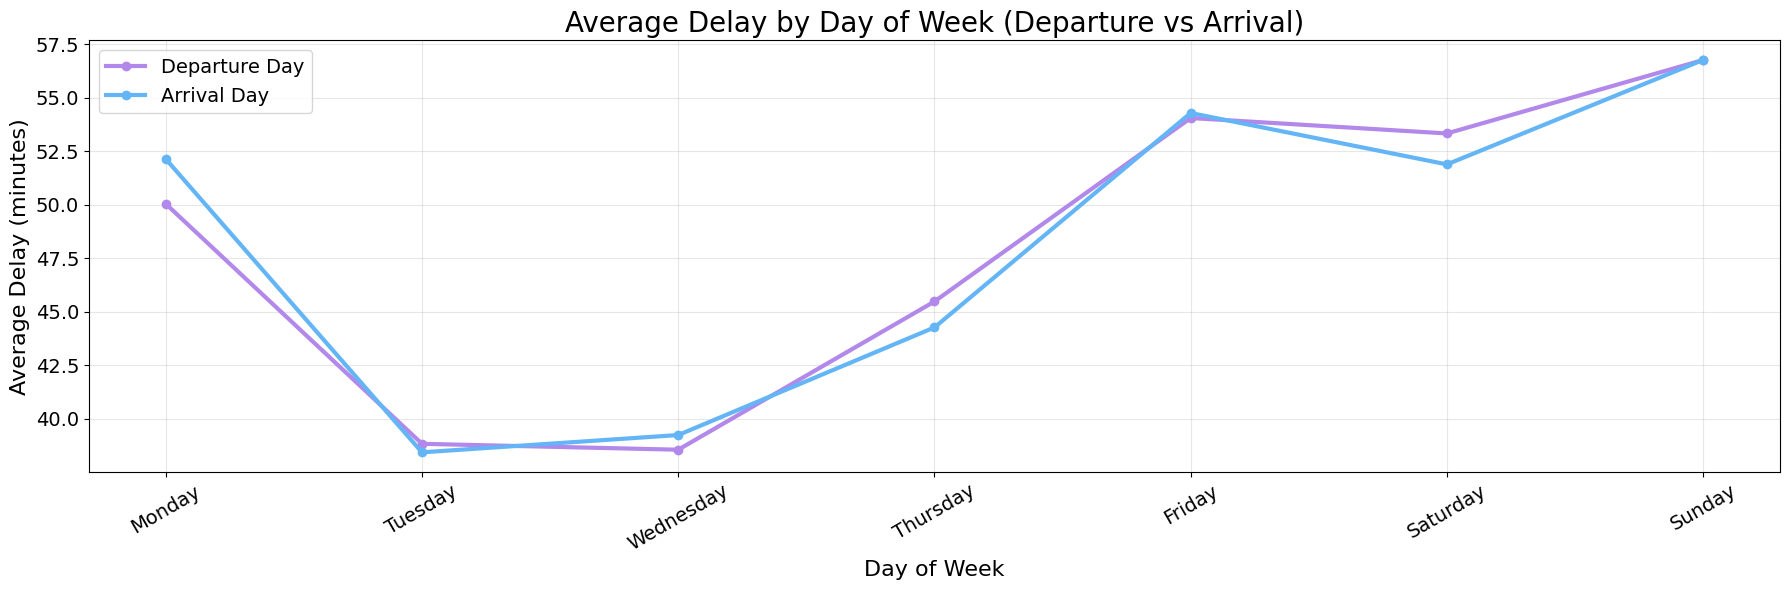

In [229]:
import matplotlib.pyplot as plt

# ----------------------------
# Average delay by day of week (Departure vs Arrival)
# ----------------------------

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

avg_delay_dep_day = (
    train_df_eda
    .groupby("dep_day")["target"]
    .mean()
    .reindex(day_order)
)

avg_delay_arr_day = (
    train_df_eda
    .groupby("arr_day")["target"]
    .mean()
    .reindex(day_order)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(18, 6))

# Departure
plt.plot(
    avg_delay_dep_day.index,
    avg_delay_dep_day.values,
    marker="o",
    linewidth=3,
    color="#B388EB",
    label="Departure Day"
)

# Arrival
plt.plot(
    avg_delay_arr_day.index,
    avg_delay_arr_day.values,
    marker="o",
    linewidth=3,
    color="#64B5F6",
    label="Arrival Day"
)

plt.title("Average Delay by Day of Week (Departure vs Arrival)", fontsize=20)
plt.xlabel("Day of Week", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation — Average Delay by Day of Week (Departure vs Arrival)**

Average delay exhibits a clear weekly pattern for both departure and arrival days.
The lowest average delays are observed on Tuesday and Wednesday, indicating more stable and less congested operations during midweek periods.

From Thursday onward, average delays increase steadily and reach their highest levels during Friday, Saturday, and especially Sunday.
This pattern is likely driven by higher passenger demand, increased flight frequency, and accumulated operational congestion during weekend peak travel periods.

The departure and arrival curves follow very similar trends across all weekdays, suggesting that the day-of-week effect is systemic and impacts the entire flight network rather than isolated operational stages.

Overall, the strong and consistent temporal structure confirms that day-of-week is a highly informative temporal feature and should be retained for downstream modeling.

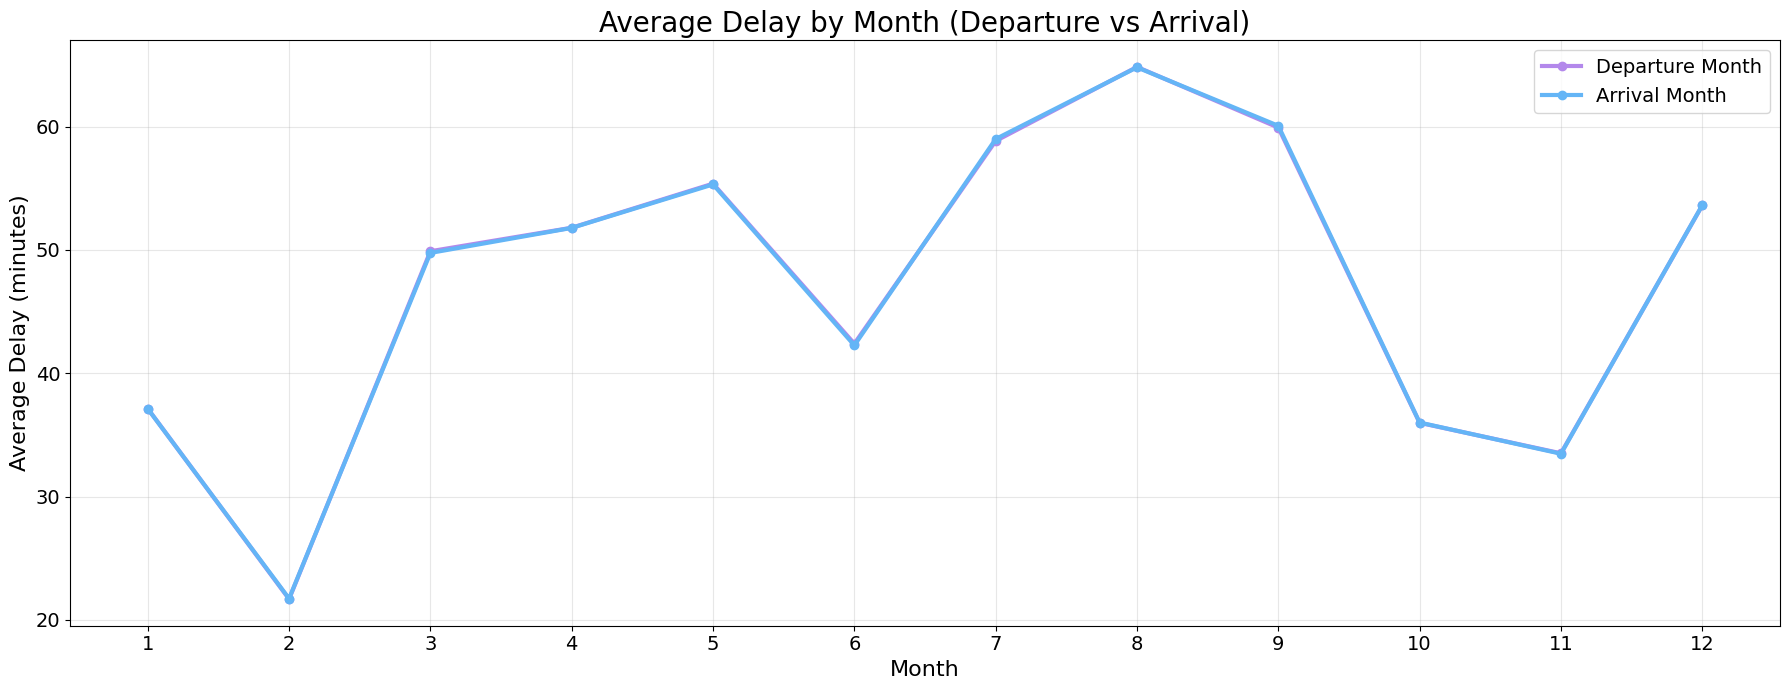

In [230]:

# ----------------------------
# Average delay by month (Departure vs Arrival)
# ----------------------------

months = range(1, 13)

dep_month_avg = (
    train_df_eda
    .groupby("dep_month")["target"]
    .mean()
    .reindex(months)
)

arr_month_avg = (
    train_df_eda
    .groupby("arr_month")["target"]
    .mean()
    .reindex(months)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(18, 7))

plt.plot(
    months,
    dep_month_avg,
    marker="o",
    color="#B388EB",
    linewidth=3,
    label="Departure Month"
)

plt.plot(
    months,
    arr_month_avg,
    marker="o",
    color="#64B5F6",
    linewidth=3,
    label="Arrival Month"
)

plt.title("Average Delay by Month (Departure vs Arrival)", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(months, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Average delay exhibits a clear seasonal pattern across the year. Both **departure** and **arrival** curves almost completely overlap, indicating that monthly effects impact the entire flight pipeline in a highly consistent manner.

Delays are lowest during winter months, particularly in **February**, and gradually increase toward late spring and summer. The highest average delays occur during **July and August**, which likely reflects peak travel demand, increased air traffic congestion, and seasonal operational constraints.

After the summer peak, delays decrease noticeably during autumn (**October–November**), followed by a moderate increase again in **December**, potentially driven by holiday travel demand.

The strong alignment between departure and arrival monthly trends suggests systematic delay propagation across flight operations. Therefore, **month** represents a meaningful seasonal feature with strong predictive signal and should be retained for modeling.


#### 5.7.3 Delay vs Spatial Features (Airports & Geography)

**5.7.3.1 Average Delay by Top Busiest Departure Airports**  

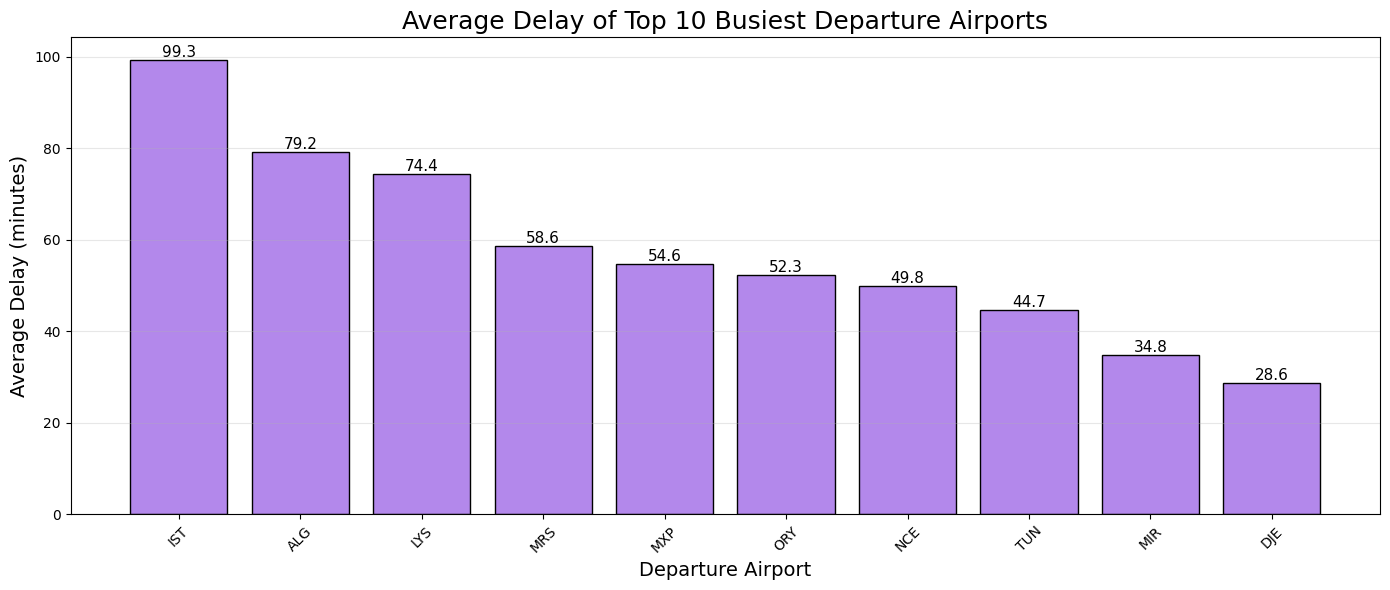

In [231]:
import matplotlib.pyplot as plt

# ----------------------------
# Select top 10 busiest departure airports
# ----------------------------

top_dep_airports = train_df_eda["DEPSTN"].value_counts().head(10).index

dep_delay_avg = (
    train_df_eda[train_df_eda["DEPSTN"].isin(top_dep_airports)]
    .groupby("DEPSTN")["target"]
    .mean()
    .sort_values(ascending=False)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(14, 6))

bars = plt.bar(
    dep_delay_avg.index,
    dep_delay_avg.values,
    color="#B388EB",
    edgecolor="black"
)

# ----------------------------
# Add average delay labels on top
# ----------------------------

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Average Delay of Top 10 Busiest Departure Airports", fontsize=18)
plt.xlabel("Departure Airport", fontsize=14)
plt.ylabel("Average Delay (minutes)", fontsize=14)

plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


**5.7.3.2 Average Delay by Top Busiest Arrival Airports**  

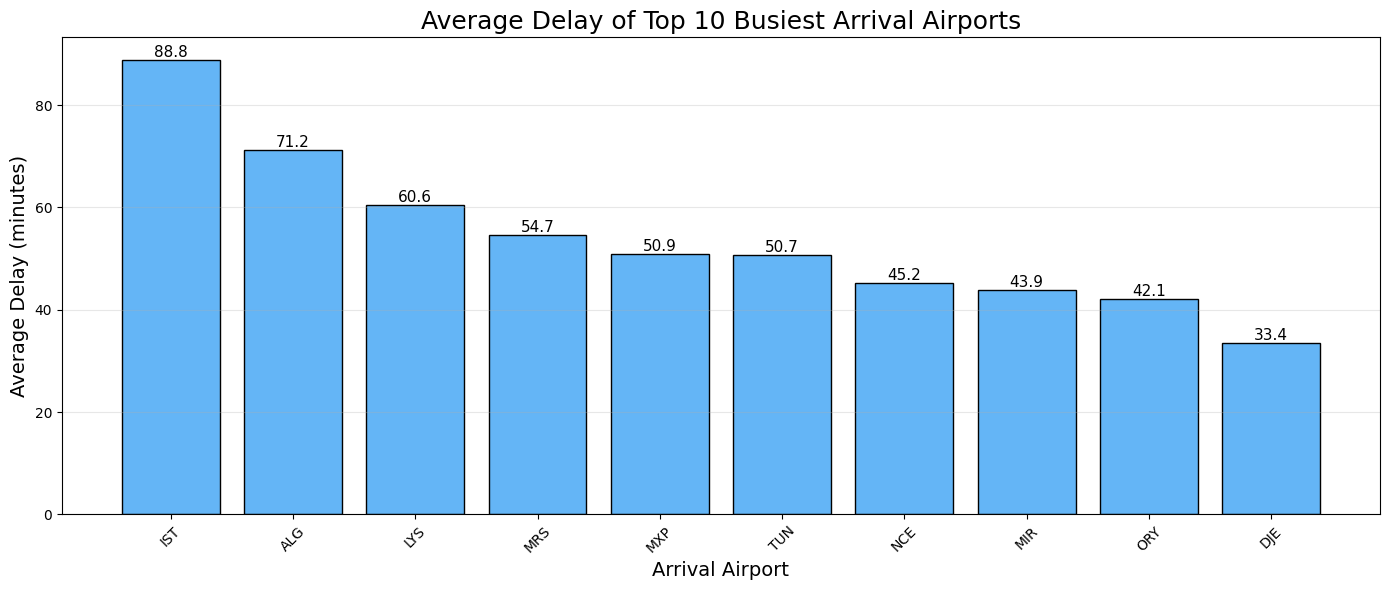

In [232]:
import matplotlib.pyplot as plt

# ----------------------------
# Select top 10 busiest arrival airports
# ----------------------------

top_arr_airports = train_df_eda["ARRSTN"].value_counts().head(10).index

arr_delay_avg = (
    train_df_eda[train_df_eda["ARRSTN"].isin(top_arr_airports)]
    .groupby("ARRSTN")["target"]
    .mean()
    .sort_values(ascending=False)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(14, 6))

bars = plt.bar(
    arr_delay_avg.index,
    arr_delay_avg.values,
    color="#64B5F6",
    edgecolor="black"
)

# ----------------------------
# Add average delay labels on top
# ----------------------------

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Average Delay of Top 10 Busiest Arrival Airports", fontsize=18)
plt.xlabel("Arrival Airport", fontsize=14)
plt.ylabel("Average Delay (minutes)", fontsize=14)

plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


**Observation**

Average delay varies substantially across the busiest departure and arrival airports, indicating strong spatial heterogeneity in delay behavior.

Airports such as IST and ALG consistently exhibit the highest average delays for both departures and arrivals, while airports like DJE, MIR, and ORY show comparatively lower delay levels.

The strong overlap between high-delay airports in both departure and arrival perspectives suggests that part of the delay pattern is driven by airport-specific operational characteristics (e.g., traffic volume, congestion, infrastructure constraints), rather than purely flight-level randomness.

Overall, origin and destination airport identifiers represent important spatial features and should be retained as predictive inputs for delay modeling.

**5.7.3.3 Delay vs Geographic Coordinates (Latitude / Longitude)**


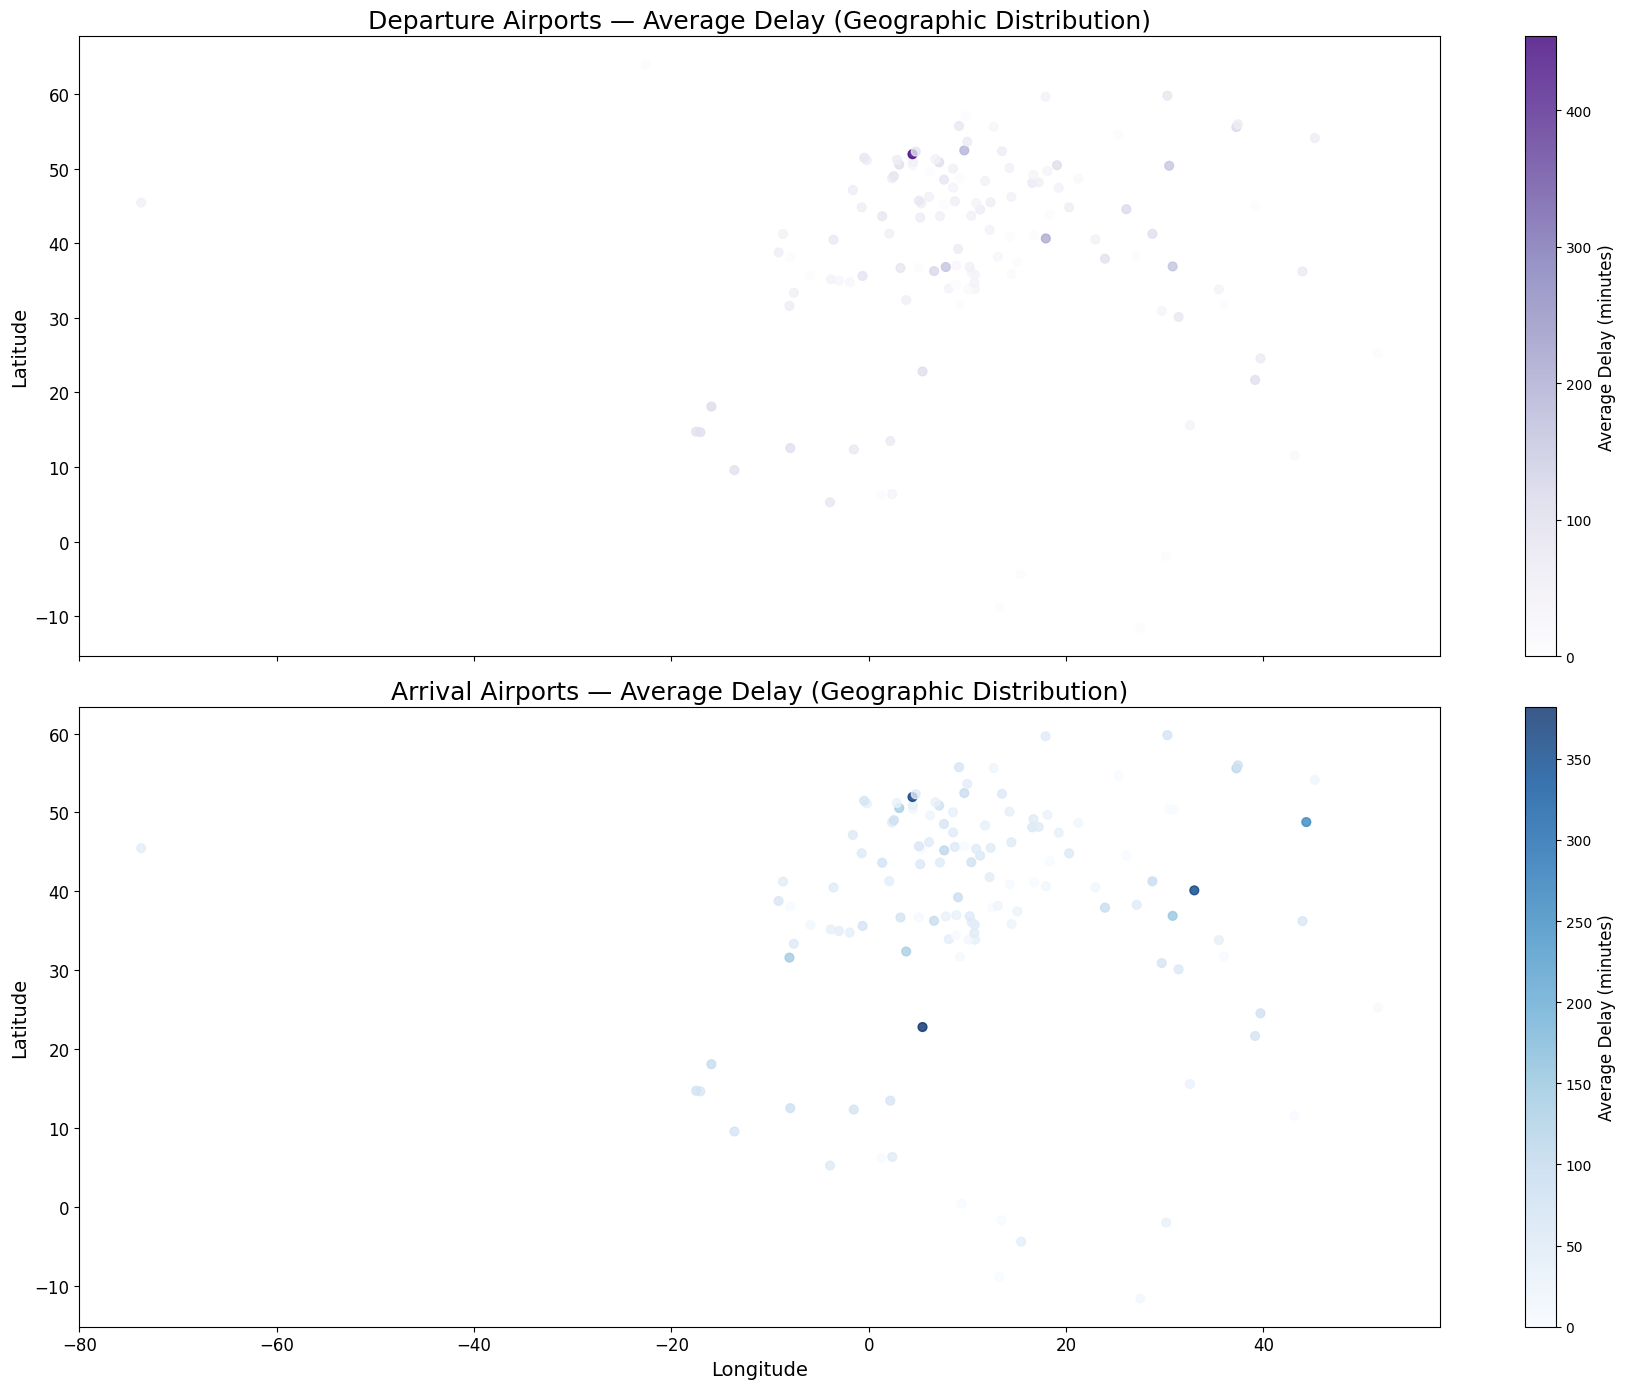

In [233]:
import matplotlib.pyplot as plt

# ----------------------------
# Prepare aggregated spatial delay data
# ----------------------------

# Departure airports: average delay per coordinate
dep_geo_delay = (
    train_df_eda
    .groupby(["dep_lat", "dep_lon"])["target"]
    .mean()
    .reset_index()
)

# Arrival airports: average delay per coordinate
arr_geo_delay = (
    train_df_eda
    .groupby(["arr_lat", "arr_lon"])["target"]
    .mean()
    .reset_index()
)

# ----------------------------
# Plot spatial scatter maps
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# ---- Departure scatter ----
sc1 = axes[0].scatter(
    dep_geo_delay["dep_lon"],
    dep_geo_delay["dep_lat"],
    c=dep_geo_delay["target"],
    cmap="Purples",
    s=40,
    alpha=0.8
)

axes[0].set_title("Departure Airports — Average Delay (Geographic Distribution)", fontsize=18)
axes[0].set_ylabel("Latitude", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)

cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label("Average Delay (minutes)", fontsize=12)

# ---- Arrival scatter ----
sc2 = axes[1].scatter(
    arr_geo_delay["arr_lon"],
    arr_geo_delay["arr_lat"],
    c=arr_geo_delay["target"],
    cmap="Blues",
    s=40,
    alpha=0.8
)

axes[1].set_title("Arrival Airports — Average Delay (Geographic Distribution)", fontsize=18)
axes[1].set_xlabel("Longitude", fontsize=14)
axes[1].set_ylabel("Latitude", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)

cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Average Delay (minutes)", fontsize=12)

plt.tight_layout()
plt.show()


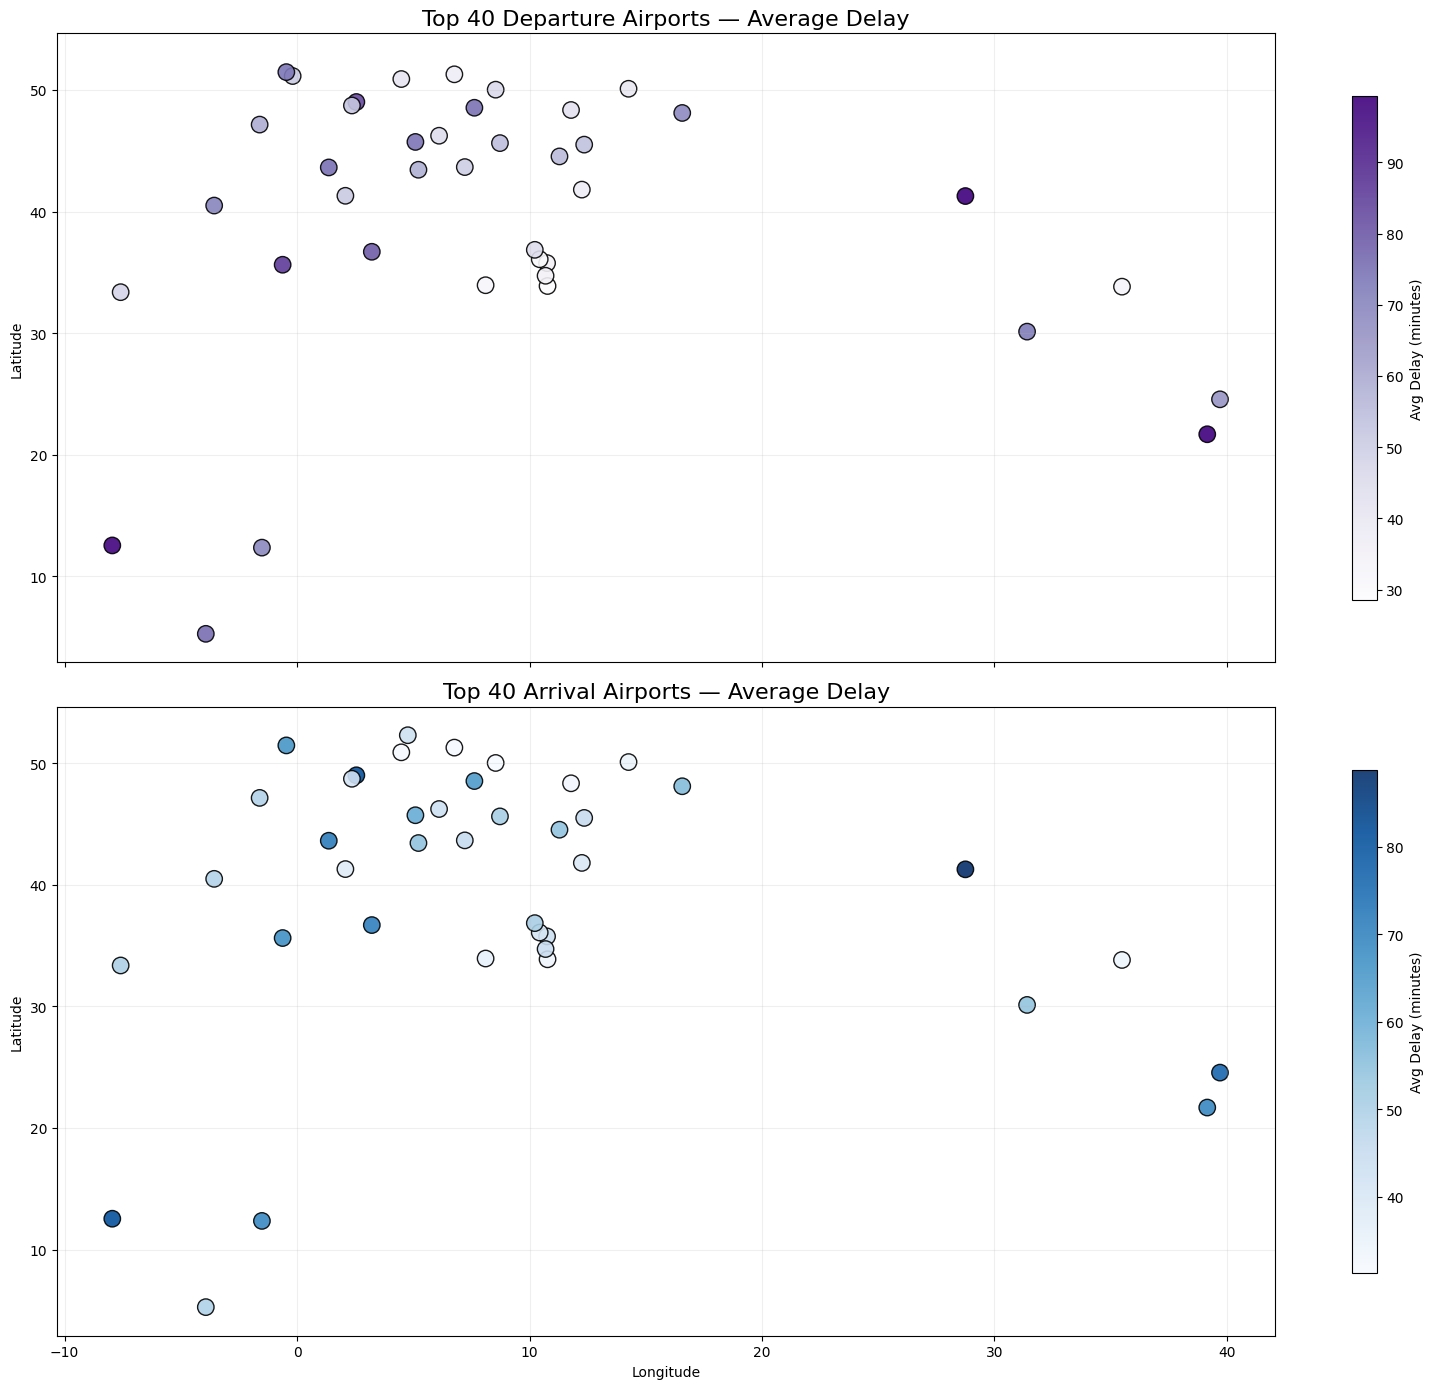

In [234]:
import matplotlib.pyplot as plt

# ----------------------------
# Top 40 busiest departure airports
# ----------------------------

top_dep = (
    train_df_eda["dep_iata"]
    .value_counts()
    .head(40)
    .index
)

dep_geo = (
    train_df_eda[train_df_eda["dep_iata"].isin(top_dep)]
    .groupby("dep_iata")
    .agg({
        "dep_lat": "mean",
        "dep_lon": "mean",
        "target": "mean"
    })
    .reset_index()
)

# ----------------------------
# Top 40 busiest arrival airports
# ----------------------------

top_arr = (
    train_df_eda["arr_iata"]
    .value_counts()
    .head(40)
    .index
)

arr_geo = (
    train_df_eda[train_df_eda["arr_iata"].isin(top_arr)]
    .groupby("arr_iata")
    .agg({
        "arr_lat": "mean",
        "arr_lon": "mean",
        "target": "mean"
    })
    .reset_index()
)

# ----------------------------
# Plot vertical layout
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True, sharey=True)

# Departure map
sc1 = axes[0].scatter(
    dep_geo["dep_lon"],
    dep_geo["dep_lat"],
    c=dep_geo["target"],
    cmap="Purples",
    s=140,
    alpha=0.9,
    edgecolor="black"
)

axes[0].set_title("Top 40 Departure Airports — Average Delay", fontsize=16)
axes[0].set_ylabel("Latitude")
axes[0].grid(alpha=0.2)

# Arrival map
sc2 = axes[1].scatter(
    arr_geo["arr_lon"],
    arr_geo["arr_lat"],
    c=arr_geo["target"],
    cmap="Blues",
    s=140,
    alpha=0.9,
    edgecolor="black"
)

axes[1].set_title("Top 40 Arrival Airports — Average Delay", fontsize=16)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(alpha=0.2)

# Colorbars
plt.colorbar(sc1, ax=axes[0], shrink=0.8, label="Avg Delay (minutes)")
plt.colorbar(sc2, ax=axes[1], shrink=0.8, label="Avg Delay (minutes)")

plt.tight_layout()
plt.show()


## 6. Target Transformation

### 6.1 Target Distribution Characteristics

Exploratory analysis showed that the delay duration target variable is highly right-skewed with a long tail of extreme delay values.  
Such skewness can negatively affect regression model stability and error optimization.

Therefore, a logarithmic transformation is applied to stabilize variance and reduce the influence of extreme outliers.


### 6.2 Log Transformation of Target Variable

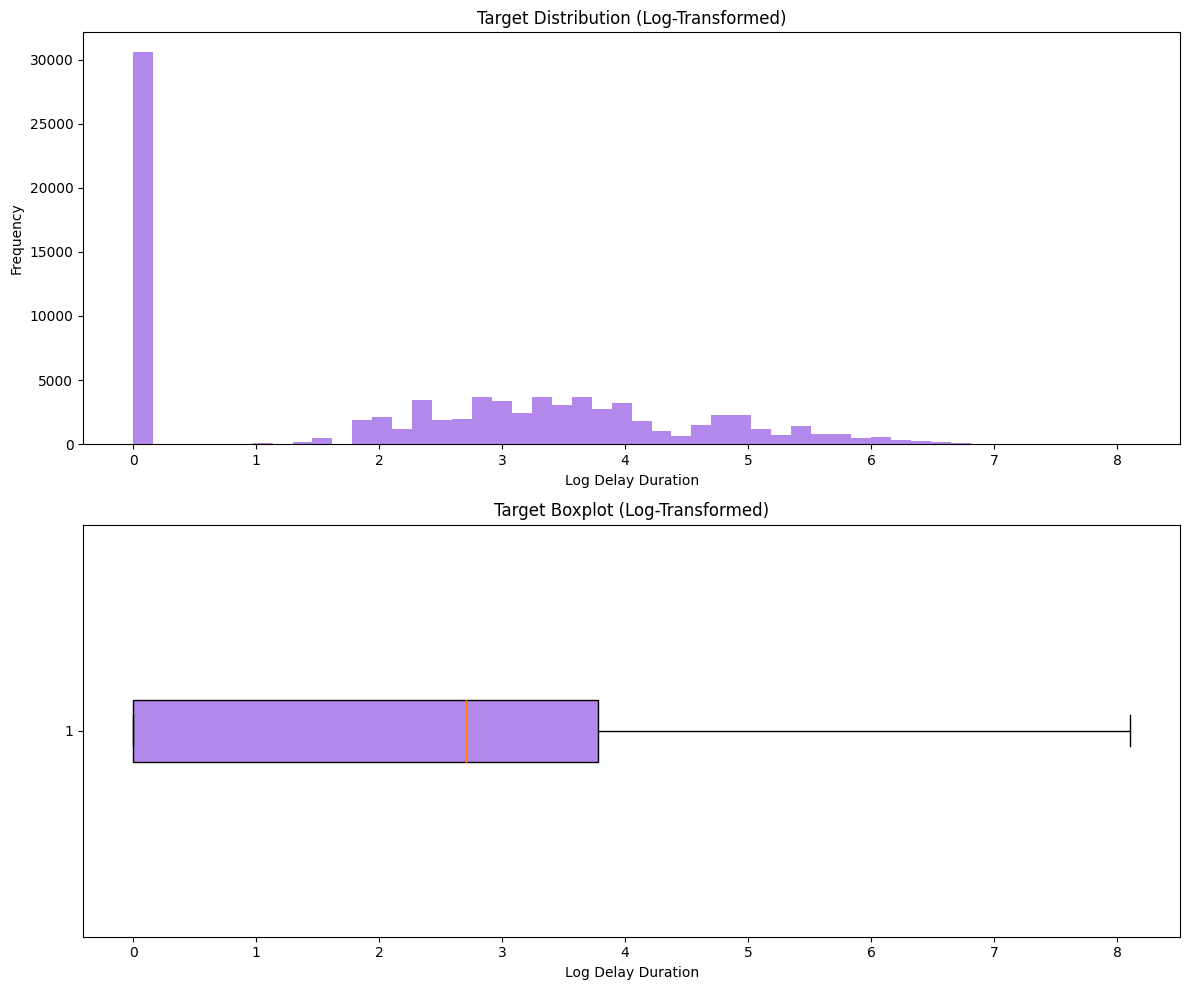

In [235]:

# ----------------------------
# Apply log transformation to target
# ----------------------------

train_df_eda["target_log"] = np.log1p(train_df_eda["target"])

# ----------------------------
# Visualize transformed target distribution
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(train_df_eda["target_log"], bins=50, color="#B388EB")
axes[0].set_title("Target Distribution (Log-Transformed)")
axes[0].set_xlabel("Log Delay Duration")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(
    train_df_eda["target_log"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#B388EB")
)
axes[1].set_title("Target Boxplot (Log-Transformed)")
axes[1].set_xlabel("Log Delay Duration")

plt.tight_layout()
plt.show()


## 7. Feature Engineering